In [9]:
from utils import (ConstructDataset,Unet_Discriminator, Unet_Discriminator_V2, Unet_Generator_V2, unet_d_criterion_without_cutmix_v2)
import random
from torchvision import transforms
import torchvision.transforms as transforms
import torch
import torch.optim as optim
from torchmetrics.image.fid import FrechetInceptionDistance
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import time
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

<strong> Building the dataset </strong>

In [10]:
# Building the dataset

image_dir = '../../data/pixel_art/images/images/'

transform = transforms.Compose([
    transforms.ToTensor(), # Transforming to tensor
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) # Normalizing
])



images = ConstructDataset(image_dir, transform)

<strong> Sampling an image from the dataset </strong>

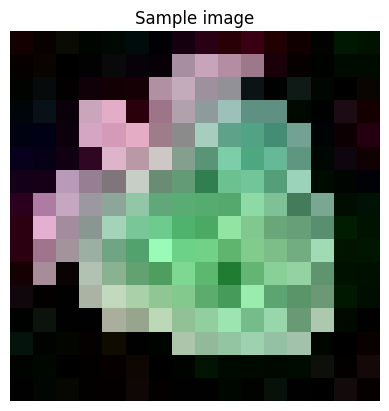

In [11]:
# Plotting an example from  the dataset
n = len(images)
integer = random.randint(0,n)
image = images[integer].numpy()*0.5 + 0.5

# Plot the image
plt.imshow(np.transpose(image, (1, 2, 0)))  
plt.axis('off')  # Hide axes
plt.title('Sample image')
plt.show()


<strong> Building the dataloader </strong>

In [12]:
dataloader = DataLoader(images, batch_size=256)

<strong> Building the models </strong>

In [13]:
latent_dim = 40
channels_out = 3
input_channels = 3
n_classes = 2

D_unet = Unet_Discriminator_V2(input_channels, n_classes)
G_unet = Unet_Generator_V2(latent_dim, channels_out)

<strong> Generating an image before training the generator </strong>

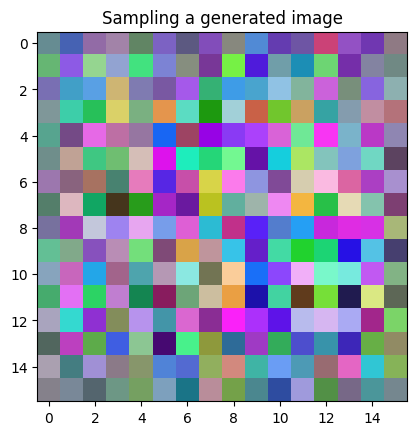

In [14]:
noise_image = D_unet(images[0].unsqueeze(0))[1][0]

# Generate random noise
noise = torch.randn(1, latent_dim, 1, 1)  # Batch of 16 noise vectors

# Generate images
fake_images = G_unet(noise)

# Plotting the image 
image_noise = fake_images.detach().numpy().reshape((3,16,16))*0.5 + 0.5

plt.imshow(np.transpose(image_noise, (1, 2, 0)))
plt.title("Sampling a generated image")
plt.show()

<strong> Training loop</strong>

In [15]:
torch.autograd.set_detect_anomaly(True)

input_channels = 3
n_classes = 2
k = 1 # Steps to train generator
latent_dim = 40

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device) 

G_unet = G_unet.to(device)
D_unet = D_unet.to(device)

criterion = unet_d_criterion_without_cutmix_v2

optimizer_g_unet = optim.Adam(G_unet.parameters(), lr=1e-4, betas=(0.5, 0.999))
optimizer_d_unet = optim.Adam(D_unet.parameters(), lr=5e-4, betas=(0.5, 0.999)) 

D_loss, G_loss = [], []

epochs = 1000
epoch_eval = epochs // 10

fid = FrechetInceptionDistance(feature=192, reset_real_features=False, normalize=True)
n_samples = 500
N = len(images)
indices = random.sample(range(N), n_samples)

real_images_eval = torch.stack([images[idx] for idx in indices])
fid.update(real_images_eval, real=True)

FID_values = []

for epoch in tqdm(range(epochs)):
    start_time = time.time()

    for batch in tqdm(dataloader):
        # Get real images
        real_images = batch.to(device)  # Move batch to GPU
        batch_size = real_images.size(0)
        labels_1 = torch.ones(batch_size, 1, device=device)  # Real labels on GPU
        labels_2 = torch.ones(batch_size, 1, device=device)

        # Train discriminator with real images
        D_unet.zero_grad()
        output = D_unet(real_images)
        loss_d_real = criterion(output, labels_1, batch_size)

        # Train discriminator with fake images
        noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)  # Generate noise on GPU
        fake_images = G_unet(noise)
        labels_2.fill_(0)  # Fake labels
        output = D_unet(fake_images.detach())
        loss_d_fake = criterion(output, labels_2, batch_size)
        
        loss_d = loss_d_fake + loss_d_real
        loss_d.backward()
        optimizer_d_unet.step()

        if epoch % k == 0:
            # Train generator
            labels_3 = torch.ones(batch_size, 1, device=device)
            G_unet.zero_grad()
            labels_3.fill_(1)  # Real labels
            output = D_unet(fake_images)
            loss_g = criterion(output, labels_3, batch_size)
            loss_g.backward()
            optimizer_g_unet.step()

    if epoch % epoch_eval == 0:
        # Eval mode
        G_unet_eval = G_unet.eval()
        # Generating fake images
        noise = torch.randn(n_samples, latent_dim, 1, 1, device=device)
        fake_images_eval = G_unet_eval(noise).to(torch.device('cpu'))
        fid.update(fake_images_eval, real=False)
        fid_value = fid.compute().item()
        FID_values.append(fid_value)
        # Storing loss values
        D_loss.append(loss_d.item())
        G_loss.append(loss_g.item())
        # Train mode
        G_unet.train()

            
    
    end_time = time.time()
    if epoch % k == 0:

        print(f'Epoch [{epoch}/{epochs}] | Loss D: {loss_d.item()} | Loss G: {loss_g.item()}')
    else:
    
        print(f'Epoch [{epoch}/{epochs}] | Loss D: {loss_d.item()}')
    
    print(f'Epoch {epoch +1} duration :   {end_time - start_time}')

cuda


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [0/1000] | Loss D: 344.1318359375 | Loss G: 187.2486114501953
Epoch 1 duration :   33.221553325653076


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [1/1000] | Loss D: 273.73321533203125 | Loss G: 224.1296844482422
Epoch 2 duration :   2.3914976119995117


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [2/1000] | Loss D: 295.648681640625 | Loss G: 288.4576721191406
Epoch 3 duration :   1.4569194316864014


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [3/1000] | Loss D: 260.9090270996094 | Loss G: 270.1378479003906
Epoch 4 duration :   1.4009230136871338


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [4/1000] | Loss D: 154.72695922851562 | Loss G: 634.8148803710938
Epoch 5 duration :   1.442068338394165


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [5/1000] | Loss D: 149.08262634277344 | Loss G: 449.6319885253906
Epoch 6 duration :   1.4280786514282227


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [6/1000] | Loss D: 65.77908325195312 | Loss G: 1255.9605712890625
Epoch 7 duration :   1.434070110321045


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [7/1000] | Loss D: 86.3348388671875 | Loss G: 1572.7713623046875
Epoch 8 duration :   1.4627995491027832


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [8/1000] | Loss D: 35.23574447631836 | Loss G: 884.697021484375
Epoch 9 duration :   1.4458024501800537


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [9/1000] | Loss D: 11.86445426940918 | Loss G: 1428.7738037109375
Epoch 10 duration :   1.410583734512329


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [10/1000] | Loss D: 2.321658134460449 | Loss G: 3029.39599609375
Epoch 11 duration :   1.4304661750793457


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [11/1000] | Loss D: 8.590874671936035 | Loss G: 4469.43896484375
Epoch 12 duration :   1.3921735286712646


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [12/1000] | Loss D: 34.39094924926758 | Loss G: 964.2241821289062
Epoch 13 duration :   1.4078850746154785


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [13/1000] | Loss D: 9.024984359741211 | Loss G: 1985.772705078125
Epoch 14 duration :   1.4464664459228516


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [14/1000] | Loss D: 5.2801923751831055 | Loss G: 2822.757568359375
Epoch 15 duration :   1.4027104377746582


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [15/1000] | Loss D: 2.001577854156494 | Loss G: 3369.692138671875
Epoch 16 duration :   1.3754067420959473


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [16/1000] | Loss D: 5.069997310638428 | Loss G: 3942.863037109375
Epoch 17 duration :   1.4176750183105469


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [17/1000] | Loss D: 0.4471237063407898 | Loss G: 4511.103515625
Epoch 18 duration :   1.3961303234100342


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [18/1000] | Loss D: 0.218610480427742 | Loss G: 5131.75048828125
Epoch 19 duration :   1.419295310974121


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [19/1000] | Loss D: 257.6922607421875 | Loss G: 228.65603637695312
Epoch 20 duration :   1.4182493686676025


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [20/1000] | Loss D: 239.37217712402344 | Loss G: 188.4439239501953
Epoch 21 duration :   1.419694185256958


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [21/1000] | Loss D: 194.041748046875 | Loss G: 238.5393829345703
Epoch 22 duration :   1.415597677230835


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [22/1000] | Loss D: 143.96878051757812 | Loss G: 323.69183349609375
Epoch 23 duration :   1.3958213329315186


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [23/1000] | Loss D: 83.33979797363281 | Loss G: 435.7541809082031
Epoch 24 duration :   1.4222540855407715


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [24/1000] | Loss D: 15.840397834777832 | Loss G: 2006.3218994140625
Epoch 25 duration :   1.4287352561950684


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [25/1000] | Loss D: 18.50794792175293 | Loss G: 1065.2139892578125
Epoch 26 duration :   1.4230871200561523


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [26/1000] | Loss D: 5.740983486175537 | Loss G: 2070.713134765625
Epoch 27 duration :   1.3998959064483643


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [27/1000] | Loss D: 4.071028709411621 | Loss G: 2209.4208984375
Epoch 28 duration :   1.456667423248291


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [28/1000] | Loss D: 6.072988033294678 | Loss G: 2333.7666015625
Epoch 29 duration :   1.4459259510040283


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [29/1000] | Loss D: 4.597940921783447 | Loss G: 2407.986572265625
Epoch 30 duration :   1.4486620426177979


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [30/1000] | Loss D: 4.197274208068848 | Loss G: 2673.847412109375
Epoch 31 duration :   1.4017078876495361


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [31/1000] | Loss D: 7.8463897705078125 | Loss G: 1854.61279296875
Epoch 32 duration :   1.437326192855835


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [32/1000] | Loss D: 2.9885761737823486 | Loss G: 2418.129638671875
Epoch 33 duration :   1.397153377532959


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [33/1000] | Loss D: 1.556596279144287 | Loss G: 3057.357421875
Epoch 34 duration :   1.435399055480957


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [34/1000] | Loss D: 5.427357196807861 | Loss G: 1883.947021484375
Epoch 35 duration :   1.404475450515747


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [35/1000] | Loss D: 5.787052631378174 | Loss G: 2186.464599609375
Epoch 36 duration :   1.4471125602722168


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [36/1000] | Loss D: 1.608985185623169 | Loss G: 3049.349609375
Epoch 37 duration :   1.3995788097381592


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [37/1000] | Loss D: 1.075023889541626 | Loss G: 3204.405517578125
Epoch 38 duration :   1.4376695156097412


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [38/1000] | Loss D: 5473.1171875 | Loss G: 508.4154357910156
Epoch 39 duration :   1.4079251289367676


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [39/1000] | Loss D: 104.47259521484375 | Loss G: 309.2967834472656
Epoch 40 duration :   1.4420089721679688


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [40/1000] | Loss D: 83.54419708251953 | Loss G: 404.1080322265625
Epoch 41 duration :   1.3985817432403564


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [41/1000] | Loss D: 64.12162017822266 | Loss G: 513.36572265625
Epoch 42 duration :   1.4275591373443604


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [42/1000] | Loss D: 37.63114547729492 | Loss G: 649.5909423828125
Epoch 43 duration :   1.4369268417358398


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [43/1000] | Loss D: 31.076255798339844 | Loss G: 780.1441650390625
Epoch 44 duration :   1.4378993511199951


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [44/1000] | Loss D: 13.748745918273926 | Loss G: 989.8644409179688
Epoch 45 duration :   1.4142565727233887


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [45/1000] | Loss D: 8.988042831420898 | Loss G: 1696.95556640625
Epoch 46 duration :   1.4229166507720947


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [46/1000] | Loss D: 2.797179698944092 | Loss G: 2564.501220703125
Epoch 47 duration :   1.4161412715911865


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [47/1000] | Loss D: 7.328012466430664 | Loss G: 3265.609619140625
Epoch 48 duration :   1.4381732940673828


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [48/1000] | Loss D: 11.481937408447266 | Loss G: 1242.3458251953125
Epoch 49 duration :   1.4395439624786377


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [49/1000] | Loss D: 10.658992767333984 | Loss G: 1409.174560546875
Epoch 50 duration :   1.4553909301757812


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [50/1000] | Loss D: 5.258717060089111 | Loss G: 1961.722412109375
Epoch 51 duration :   1.4385488033294678


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [51/1000] | Loss D: 2.8359382152557373 | Loss G: 2270.116455078125
Epoch 52 duration :   1.4409890174865723


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [52/1000] | Loss D: 2.065471887588501 | Loss G: 2507.263671875
Epoch 53 duration :   1.4215762615203857


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [53/1000] | Loss D: 125.5191879272461 | Loss G: 1720.0882568359375
Epoch 54 duration :   1.4610440731048584


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [54/1000] | Loss D: 46.054481506347656 | Loss G: 2299.16455078125
Epoch 55 duration :   1.3947622776031494


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [55/1000] | Loss D: 19.739534378051758 | Loss G: 2097.1728515625
Epoch 56 duration :   1.4351279735565186


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [56/1000] | Loss D: 26.126907348632812 | Loss G: 1529.3297119140625
Epoch 57 duration :   1.4182002544403076


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [57/1000] | Loss D: 16.385761260986328 | Loss G: 1902.81591796875
Epoch 58 duration :   1.4456021785736084


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [58/1000] | Loss D: 6.4740400314331055 | Loss G: 2430.551025390625
Epoch 59 duration :   1.418034315109253


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [59/1000] | Loss D: 5.079319477081299 | Loss G: 2413.53759765625
Epoch 60 duration :   1.4343323707580566


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [60/1000] | Loss D: 7.804096698760986 | Loss G: 3138.47705078125
Epoch 61 duration :   1.426499366760254


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [61/1000] | Loss D: 4.797971248626709 | Loss G: 3564.895263671875
Epoch 62 duration :   1.4242527484893799


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [62/1000] | Loss D: 592.0802001953125 | Loss G: 5.839944362640381
Epoch 63 duration :   1.397122859954834


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [63/1000] | Loss D: 310.58087158203125 | Loss G: 374.3016662597656
Epoch 64 duration :   1.4333312511444092


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [64/1000] | Loss D: 238.27621459960938 | Loss G: 438.9197082519531
Epoch 65 duration :   1.406886100769043


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [65/1000] | Loss D: 187.3278350830078 | Loss G: 438.23040771484375
Epoch 66 duration :   1.4172701835632324


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [66/1000] | Loss D: 165.95420837402344 | Loss G: 534.7447509765625
Epoch 67 duration :   1.3990697860717773


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [67/1000] | Loss D: 152.22955322265625 | Loss G: 569.259765625
Epoch 68 duration :   1.4248178005218506


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [68/1000] | Loss D: 99.98653411865234 | Loss G: 671.515869140625
Epoch 69 duration :   1.4216868877410889


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [69/1000] | Loss D: 446.8857421875 | Loss G: 671.1721801757812
Epoch 70 duration :   1.4627606868743896


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [70/1000] | Loss D: 236.31747436523438 | Loss G: 327.5773010253906
Epoch 71 duration :   1.436833381652832


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [71/1000] | Loss D: 220.0334014892578 | Loss G: 371.8331604003906
Epoch 72 duration :   1.4738361835479736


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [72/1000] | Loss D: 207.18093872070312 | Loss G: 402.0062255859375
Epoch 73 duration :   1.4332139492034912


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [73/1000] | Loss D: 206.176025390625 | Loss G: 465.04547119140625
Epoch 74 duration :   1.4293558597564697


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [74/1000] | Loss D: 280.8656005859375 | Loss G: 295.0034484863281
Epoch 75 duration :   1.4094254970550537


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [75/1000] | Loss D: 188.7696533203125 | Loss G: 483.70709228515625
Epoch 76 duration :   1.4244005680084229


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [76/1000] | Loss D: 172.18443298339844 | Loss G: 543.4066772460938
Epoch 77 duration :   1.3875603675842285


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [77/1000] | Loss D: 139.13656616210938 | Loss G: 578.5375366210938
Epoch 78 duration :   1.4161350727081299


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [78/1000] | Loss D: 195.91732788085938 | Loss G: 125.8595199584961
Epoch 79 duration :   1.419635534286499


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [79/1000] | Loss D: 404.22283935546875 | Loss G: 384.0638122558594
Epoch 80 duration :   1.417912244796753


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [80/1000] | Loss D: 305.8424072265625 | Loss G: 378.60687255859375
Epoch 81 duration :   1.4118351936340332


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [81/1000] | Loss D: 286.87603759765625 | Loss G: 390.3511657714844
Epoch 82 duration :   1.4295153617858887


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [82/1000] | Loss D: 270.6844787597656 | Loss G: 432.4143371582031
Epoch 83 duration :   1.4227499961853027


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [83/1000] | Loss D: 234.2369842529297 | Loss G: 444.91278076171875
Epoch 84 duration :   1.4681673049926758


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [84/1000] | Loss D: 142.88970947265625 | Loss G: 5072.58837890625
Epoch 85 duration :   1.4330365657806396


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [85/1000] | Loss D: 279.5965576171875 | Loss G: 235.77999877929688
Epoch 86 duration :   1.4820303916931152


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [86/1000] | Loss D: 211.03488159179688 | Loss G: 711.7213745117188
Epoch 87 duration :   1.4358694553375244


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [87/1000] | Loss D: 164.9156951904297 | Loss G: 1351.923095703125
Epoch 88 duration :   1.447685956954956


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [88/1000] | Loss D: 181.4004364013672 | Loss G: 1214.8731689453125
Epoch 89 duration :   1.4206609725952148


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [89/1000] | Loss D: 43.46050262451172 | Loss G: 4183.95458984375
Epoch 90 duration :   1.475921392440796


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [90/1000] | Loss D: 2.8692049980163574 | Loss G: 4873.7294921875
Epoch 91 duration :   1.4271678924560547


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [91/1000] | Loss D: 18803.638671875 | Loss G: 57.895538330078125
Epoch 92 duration :   1.4659011363983154


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [92/1000] | Loss D: 305.96539306640625 | Loss G: 249.506591796875
Epoch 93 duration :   1.447312355041504


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [93/1000] | Loss D: 275.2637939453125 | Loss G: 277.1823425292969
Epoch 94 duration :   1.4233379364013672


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [94/1000] | Loss D: 263.20892333984375 | Loss G: 314.8433532714844
Epoch 95 duration :   1.4157049655914307


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [95/1000] | Loss D: 243.58189392089844 | Loss G: 368.1352844238281
Epoch 96 duration :   1.4350390434265137


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [96/1000] | Loss D: 233.61953735351562 | Loss G: 406.630615234375
Epoch 97 duration :   1.4029202461242676


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [97/1000] | Loss D: 196.90553283691406 | Loss G: 533.8882446289062
Epoch 98 duration :   1.4383559226989746


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [98/1000] | Loss D: 148.33544921875 | Loss G: 639.3018798828125
Epoch 99 duration :   1.4126288890838623


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [99/1000] | Loss D: 125.96954345703125 | Loss G: 2326.902099609375
Epoch 100 duration :   1.4254498481750488


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [100/1000] | Loss D: 114.91114807128906 | Loss G: 1538.8555908203125
Epoch 101 duration :   18.286024570465088


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [101/1000] | Loss D: 96.88340759277344 | Loss G: 2032.3868408203125
Epoch 102 duration :   2.2542996406555176


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [102/1000] | Loss D: 47.10979461669922 | Loss G: 1891.7412109375
Epoch 103 duration :   1.4958982467651367


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [103/1000] | Loss D: 86.88467407226562 | Loss G: 1328.9383544921875
Epoch 104 duration :   1.5144374370574951


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [104/1000] | Loss D: 48.12370300292969 | Loss G: 2421.048828125
Epoch 105 duration :   1.4736104011535645


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [105/1000] | Loss D: 79.19683074951172 | Loss G: 886.8772583007812
Epoch 106 duration :   1.4208965301513672


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [106/1000] | Loss D: 12.427042961120605 | Loss G: 3259.510009765625
Epoch 107 duration :   1.446746587753296


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [107/1000] | Loss D: 264.2966003417969 | Loss G: 217.4346923828125
Epoch 108 duration :   1.4501934051513672


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [108/1000] | Loss D: 229.36325073242188 | Loss G: 297.72650146484375
Epoch 109 duration :   1.4435245990753174


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [109/1000] | Loss D: 152.8930206298828 | Loss G: 425.1346740722656
Epoch 110 duration :   1.4125239849090576


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [110/1000] | Loss D: 98.58425903320312 | Loss G: 523.2633056640625
Epoch 111 duration :   1.4415781497955322


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [111/1000] | Loss D: 48.234825134277344 | Loss G: 664.510986328125
Epoch 112 duration :   1.4007909297943115


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [112/1000] | Loss D: 31.629737854003906 | Loss G: 790.5613403320312
Epoch 113 duration :   1.4399144649505615


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [113/1000] | Loss D: 100.32691192626953 | Loss G: 652.7196655273438
Epoch 114 duration :   1.4305753707885742


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [114/1000] | Loss D: 38.401092529296875 | Loss G: 722.504150390625
Epoch 115 duration :   1.4407179355621338


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [115/1000] | Loss D: 22.7740478515625 | Loss G: 867.3814086914062
Epoch 116 duration :   1.4331893920898438


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [116/1000] | Loss D: 14.631251335144043 | Loss G: 985.0476684570312
Epoch 117 duration :   1.3959567546844482


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [117/1000] | Loss D: 15.06773567199707 | Loss G: 1069.440673828125
Epoch 118 duration :   1.4377846717834473


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [118/1000] | Loss D: 10.344225883483887 | Loss G: 1151.2369384765625
Epoch 119 duration :   1.4317693710327148


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [119/1000] | Loss D: 13.62391185760498 | Loss G: 1147.7618408203125
Epoch 120 duration :   1.4517698287963867


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [120/1000] | Loss D: 7.396872520446777 | Loss G: 1218.68017578125
Epoch 121 duration :   1.4226205348968506


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [121/1000] | Loss D: 12.915142059326172 | Loss G: 1286.2406005859375
Epoch 122 duration :   1.459855079650879


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [122/1000] | Loss D: 55.91134262084961 | Loss G: 870.4708862304688
Epoch 123 duration :   1.4507255554199219


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [123/1000] | Loss D: 102.58728790283203 | Loss G: 644.0006103515625
Epoch 124 duration :   1.4211339950561523


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [124/1000] | Loss D: 37.474613189697266 | Loss G: 684.5408325195312
Epoch 125 duration :   1.434842824935913


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [125/1000] | Loss D: 20.78883171081543 | Loss G: 844.0353393554688
Epoch 126 duration :   1.439974069595337


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [126/1000] | Loss D: 13.546525001525879 | Loss G: 942.6312866210938
Epoch 127 duration :   1.4496712684631348


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [127/1000] | Loss D: 10.225802421569824 | Loss G: 1050.869384765625
Epoch 128 duration :   1.4206900596618652


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [128/1000] | Loss D: 8.190585136413574 | Loss G: 1098.7733154296875
Epoch 129 duration :   1.4396898746490479


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [129/1000] | Loss D: 6.956870079040527 | Loss G: 1155.9178466796875
Epoch 130 duration :   1.4477944374084473


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [130/1000] | Loss D: 8.197209358215332 | Loss G: 1217.4619140625
Epoch 131 duration :   1.4431099891662598


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [131/1000] | Loss D: 5.3275322914123535 | Loss G: 1255.350341796875
Epoch 132 duration :   1.4250001907348633


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [132/1000] | Loss D: 4.928439617156982 | Loss G: 1280.870849609375
Epoch 133 duration :   1.4626128673553467


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [133/1000] | Loss D: 6.52094030380249 | Loss G: 1345.429443359375
Epoch 134 duration :   1.4082012176513672


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [134/1000] | Loss D: 3.829773187637329 | Loss G: 1385.70751953125
Epoch 135 duration :   1.4624557495117188


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [135/1000] | Loss D: 5.111552715301514 | Loss G: 1422.5062255859375
Epoch 136 duration :   1.4389457702636719


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [136/1000] | Loss D: 3.368464231491089 | Loss G: 1428.4395751953125
Epoch 137 duration :   1.4442975521087646


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [137/1000] | Loss D: 3.143115282058716 | Loss G: 1470.9532470703125
Epoch 138 duration :   1.454629898071289


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [138/1000] | Loss D: 2.916029453277588 | Loss G: 1496.935302734375
Epoch 139 duration :   1.4154622554779053


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [139/1000] | Loss D: 2.6167232990264893 | Loss G: 1557.521240234375
Epoch 140 duration :   1.4645817279815674


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [140/1000] | Loss D: 6.462482452392578 | Loss G: 1566.28759765625
Epoch 141 duration :   1.3999969959259033


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [141/1000] | Loss D: 2.4353761672973633 | Loss G: 1576.6998291015625
Epoch 142 duration :   1.436063289642334


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [142/1000] | Loss D: 2.3111352920532227 | Loss G: 1593.120361328125
Epoch 143 duration :   1.420179843902588


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [143/1000] | Loss D: 2.695159435272217 | Loss G: 1619.734130859375
Epoch 144 duration :   1.5183219909667969


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [144/1000] | Loss D: 2.1094815731048584 | Loss G: 1635.593994140625
Epoch 145 duration :   1.4152319431304932


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [145/1000] | Loss D: 2.0560898780822754 | Loss G: 1644.972900390625
Epoch 146 duration :   1.4875702857971191


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [146/1000] | Loss D: 1.9596868753433228 | Loss G: 1668.6817626953125
Epoch 147 duration :   1.489518642425537


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [147/1000] | Loss D: 1.9167206287384033 | Loss G: 1679.4713134765625
Epoch 148 duration :   1.4463295936584473


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [148/1000] | Loss D: 1.8193790912628174 | Loss G: 1697.744140625
Epoch 149 duration :   1.429004430770874


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [149/1000] | Loss D: 1.8568651676177979 | Loss G: 1717.0693359375
Epoch 150 duration :   1.4745218753814697


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [150/1000] | Loss D: 1.6962631940841675 | Loss G: 1733.4703369140625
Epoch 151 duration :   1.4492762088775635


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [151/1000] | Loss D: 1.6856707334518433 | Loss G: 1730.6475830078125
Epoch 152 duration :   1.4394564628601074


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [152/1000] | Loss D: 6.297820568084717 | Loss G: 1788.7296142578125
Epoch 153 duration :   1.4187777042388916


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [153/1000] | Loss D: 331.578857421875 | Loss G: 51.23720932006836
Epoch 154 duration :   1.4506328105926514


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [154/1000] | Loss D: 250.74935913085938 | Loss G: 420.790771484375
Epoch 155 duration :   1.4359891414642334


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [155/1000] | Loss D: 156.62391662597656 | Loss G: 750.8811645507812
Epoch 156 duration :   1.4549026489257812


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [156/1000] | Loss D: 35.68389892578125 | Loss G: 903.3494873046875
Epoch 157 duration :   1.405456304550171


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [157/1000] | Loss D: 14.073980331420898 | Loss G: 1059.8441162109375
Epoch 158 duration :   1.4806087017059326


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [158/1000] | Loss D: 10.027791023254395 | Loss G: 1154.46826171875
Epoch 159 duration :   1.4358305931091309


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [159/1000] | Loss D: 12.773350715637207 | Loss G: 1210.3941650390625
Epoch 160 duration :   1.461402177810669


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [160/1000] | Loss D: 7.2166547775268555 | Loss G: 1223.4097900390625
Epoch 161 duration :   1.439328908920288


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [161/1000] | Loss D: 4.929089546203613 | Loss G: 1284.7703857421875
Epoch 162 duration :   1.4713225364685059


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [162/1000] | Loss D: 4.365572929382324 | Loss G: 1341.0654296875
Epoch 163 duration :   1.4605903625488281


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [163/1000] | Loss D: 3.4717371463775635 | Loss G: 1421.9482421875
Epoch 164 duration :   1.4281158447265625


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [164/1000] | Loss D: 2.8774573802948 | Loss G: 1486.95263671875
Epoch 165 duration :   1.4780585765838623


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [165/1000] | Loss D: 2.378650426864624 | Loss G: 1581.8212890625
Epoch 166 duration :   1.4319026470184326


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [166/1000] | Loss D: 2.0261690616607666 | Loss G: 1672.3701171875
Epoch 167 duration :   1.4347705841064453


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [167/1000] | Loss D: 1.733976125717163 | Loss G: 1788.2958984375
Epoch 168 duration :   1.415769338607788


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [168/1000] | Loss D: 1.4592831134796143 | Loss G: 1918.537841796875
Epoch 169 duration :   1.4830002784729004


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [169/1000] | Loss D: 1.2881510257720947 | Loss G: 2063.984375
Epoch 170 duration :   1.421262502670288


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [170/1000] | Loss D: 4.006674289703369 | Loss G: 2209.636962890625
Epoch 171 duration :   1.4524314403533936


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [171/1000] | Loss D: 3736.559814453125 | Loss G: 1460.24951171875
Epoch 172 duration :   1.4241597652435303


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [172/1000] | Loss D: 356.5001220703125 | Loss G: 187.18798828125
Epoch 173 duration :   1.4313209056854248


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [173/1000] | Loss D: 355.7294006347656 | Loss G: 186.79855346679688
Epoch 174 duration :   1.4245073795318604


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [174/1000] | Loss D: 353.89471435546875 | Loss G: 182.49929809570312
Epoch 175 duration :   1.4299588203430176


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [175/1000] | Loss D: 352.3096923828125 | Loss G: 182.97877502441406
Epoch 176 duration :   1.4502944946289062


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [176/1000] | Loss D: 350.86920166015625 | Loss G: 182.54147338867188
Epoch 177 duration :   1.4366366863250732


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [177/1000] | Loss D: 349.02752685546875 | Loss G: 181.61721801757812
Epoch 178 duration :   1.448319673538208


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [178/1000] | Loss D: 346.6961669921875 | Loss G: 180.5185546875
Epoch 179 duration :   1.4108636379241943


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [179/1000] | Loss D: 343.76708984375 | Loss G: 179.24200439453125
Epoch 180 duration :   1.4988892078399658


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [180/1000] | Loss D: 338.61541748046875 | Loss G: 177.9974365234375
Epoch 181 duration :   1.4435968399047852


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [181/1000] | Loss D: 331.50909423828125 | Loss G: 175.26797485351562
Epoch 182 duration :   1.4440300464630127


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [182/1000] | Loss D: 323.2604064941406 | Loss G: 173.37437438964844
Epoch 183 duration :   1.4419357776641846


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [183/1000] | Loss D: 311.1450500488281 | Loss G: 172.26332092285156
Epoch 184 duration :   1.4683716297149658


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [184/1000] | Loss D: 292.6549987792969 | Loss G: 169.03451538085938
Epoch 185 duration :   1.4289000034332275


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [185/1000] | Loss D: 352.1711120605469 | Loss G: 187.98829650878906
Epoch 186 duration :   1.466909408569336


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [186/1000] | Loss D: 318.0397644042969 | Loss G: 368.23602294921875
Epoch 187 duration :   1.4666237831115723


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [187/1000] | Loss D: 307.7968444824219 | Loss G: 393.2118225097656
Epoch 188 duration :   1.4387321472167969


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [188/1000] | Loss D: 300.3264465332031 | Loss G: 449.62176513671875
Epoch 189 duration :   1.447035312652588


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [189/1000] | Loss D: 287.2381896972656 | Loss G: 439.021240234375
Epoch 190 duration :   1.4897675514221191


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [190/1000] | Loss D: 283.9145202636719 | Loss G: 436.7562255859375
Epoch 191 duration :   1.4356143474578857


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [191/1000] | Loss D: 279.586669921875 | Loss G: 441.491455078125
Epoch 192 duration :   1.4546093940734863


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [192/1000] | Loss D: 278.4300231933594 | Loss G: 432.16485595703125
Epoch 193 duration :   1.451883316040039


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [193/1000] | Loss D: 272.41107177734375 | Loss G: 449.7126159667969
Epoch 194 duration :   1.4973163604736328


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [194/1000] | Loss D: 273.47357177734375 | Loss G: 413.7239074707031
Epoch 195 duration :   1.4455969333648682


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [195/1000] | Loss D: 266.484130859375 | Loss G: 423.0892639160156
Epoch 196 duration :   1.4494929313659668


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [196/1000] | Loss D: 261.0633544921875 | Loss G: 428.4029235839844
Epoch 197 duration :   1.4918899536132812


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [197/1000] | Loss D: 251.6476593017578 | Loss G: 451.7435607910156
Epoch 198 duration :   1.517730712890625


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [198/1000] | Loss D: 248.26602172851562 | Loss G: 445.8841247558594
Epoch 199 duration :   1.5352742671966553


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [199/1000] | Loss D: 221.55047607421875 | Loss G: 579.0479125976562
Epoch 200 duration :   1.662482738494873


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [200/1000] | Loss D: 262.2553405761719 | Loss G: 276.58258056640625
Epoch 201 duration :   14.498718738555908


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [201/1000] | Loss D: 200.7202606201172 | Loss G: 445.8772277832031
Epoch 202 duration :   2.2354471683502197


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [202/1000] | Loss D: 174.40391540527344 | Loss G: 589.546142578125
Epoch 203 duration :   1.4501514434814453


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [203/1000] | Loss D: 359.97088623046875 | Loss G: 142.8653564453125
Epoch 204 duration :   1.4500105381011963


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [204/1000] | Loss D: 279.0805358886719 | Loss G: 388.0536193847656
Epoch 205 duration :   1.4057071208953857


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [205/1000] | Loss D: 200.95545959472656 | Loss G: 330.00177001953125
Epoch 206 duration :   1.4539809226989746


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [206/1000] | Loss D: 165.59136962890625 | Loss G: 350.9160461425781
Epoch 207 duration :   1.3871512413024902


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [207/1000] | Loss D: 197.97048950195312 | Loss G: 700.321533203125
Epoch 208 duration :   1.4617643356323242


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [208/1000] | Loss D: 157.92486572265625 | Loss G: 605.592529296875
Epoch 209 duration :   1.4222114086151123


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [209/1000] | Loss D: 131.5157928466797 | Loss G: 433.95843505859375
Epoch 210 duration :   1.464869737625122


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [210/1000] | Loss D: 240.0572052001953 | Loss G: 492.33367919921875
Epoch 211 duration :   1.4112145900726318


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [211/1000] | Loss D: 159.23825073242188 | Loss G: 483.3087158203125
Epoch 212 duration :   1.4508957862854004


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [212/1000] | Loss D: 130.14523315429688 | Loss G: 519.87841796875
Epoch 213 duration :   1.4447269439697266


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [213/1000] | Loss D: 108.88333892822266 | Loss G: 644.651123046875
Epoch 214 duration :   2.4623496532440186


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [214/1000] | Loss D: 869.7035522460938 | Loss G: 80.7906723022461
Epoch 215 duration :   1.4368855953216553


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [215/1000] | Loss D: 252.99346923828125 | Loss G: 293.94012451171875
Epoch 216 duration :   1.4335930347442627


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [216/1000] | Loss D: 188.732177734375 | Loss G: 354.2093505859375
Epoch 217 duration :   1.4579660892486572


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [217/1000] | Loss D: 128.730712890625 | Loss G: 541.1141357421875
Epoch 218 duration :   1.4341552257537842


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [218/1000] | Loss D: 103.19638061523438 | Loss G: 487.90386962890625
Epoch 219 duration :   1.4529743194580078


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [219/1000] | Loss D: 95.41443634033203 | Loss G: 781.729736328125
Epoch 220 duration :   1.4236736297607422


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [220/1000] | Loss D: 62.98045349121094 | Loss G: 783.1063232421875
Epoch 221 duration :   1.4344170093536377


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [221/1000] | Loss D: 38.90288543701172 | Loss G: 1198.3189697265625
Epoch 222 duration :   1.3981025218963623


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [222/1000] | Loss D: 2503.695556640625 | Loss G: 63.09596633911133
Epoch 223 duration :   1.4514141082763672


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [223/1000] | Loss D: 354.05792236328125 | Loss G: 177.4091796875
Epoch 224 duration :   1.4296679496765137


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [224/1000] | Loss D: 351.5323486328125 | Loss G: 174.2658233642578
Epoch 225 duration :   1.4505705833435059


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [225/1000] | Loss D: 336.87725830078125 | Loss G: 158.99258422851562
Epoch 226 duration :   1.4580302238464355


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [226/1000] | Loss D: 325.4871826171875 | Loss G: 161.74789428710938
Epoch 227 duration :   1.5194833278656006


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [227/1000] | Loss D: 310.9769287109375 | Loss G: 160.48231506347656
Epoch 228 duration :   1.4616317749023438


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [228/1000] | Loss D: 287.24371337890625 | Loss G: 177.5691680908203
Epoch 229 duration :   1.49265456199646


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [229/1000] | Loss D: 319.7427978515625 | Loss G: 178.1776123046875
Epoch 230 duration :   1.4354219436645508


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [230/1000] | Loss D: 266.0144348144531 | Loss G: 178.77003479003906
Epoch 231 duration :   1.4788858890533447


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [231/1000] | Loss D: 243.102783203125 | Loss G: 180.79966735839844
Epoch 232 duration :   1.4829962253570557


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [232/1000] | Loss D: 211.02639770507812 | Loss G: 173.3136444091797
Epoch 233 duration :   1.498359203338623


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [233/1000] | Loss D: 180.20518493652344 | Loss G: 183.33384704589844
Epoch 234 duration :   1.5084855556488037


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [234/1000] | Loss D: 253.18292236328125 | Loss G: 180.96507263183594
Epoch 235 duration :   1.4291257858276367


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [235/1000] | Loss D: 306.9491882324219 | Loss G: 171.13719177246094
Epoch 236 duration :   1.4467754364013672


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [236/1000] | Loss D: 349.6839294433594 | Loss G: 184.78318786621094
Epoch 237 duration :   1.4318113327026367


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [237/1000] | Loss D: 330.38983154296875 | Loss G: 176.52879333496094
Epoch 238 duration :   1.4843735694885254


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [238/1000] | Loss D: 315.8453674316406 | Loss G: 166.57504272460938
Epoch 239 duration :   1.4315266609191895


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [239/1000] | Loss D: 310.6998291015625 | Loss G: 169.05789184570312
Epoch 240 duration :   1.4287278652191162


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [240/1000] | Loss D: 306.58599853515625 | Loss G: 168.80763244628906
Epoch 241 duration :   1.4469366073608398


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [241/1000] | Loss D: 301.18206787109375 | Loss G: 169.80885314941406
Epoch 242 duration :   1.4857337474822998


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [242/1000] | Loss D: 296.6436767578125 | Loss G: 170.94244384765625
Epoch 243 duration :   1.4533300399780273


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [243/1000] | Loss D: 291.41412353515625 | Loss G: 172.04287719726562
Epoch 244 duration :   1.5624499320983887


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [244/1000] | Loss D: 287.25103759765625 | Loss G: 172.6105499267578
Epoch 245 duration :   1.486833095550537


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [245/1000] | Loss D: 281.190673828125 | Loss G: 173.69493103027344
Epoch 246 duration :   1.4637558460235596


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [246/1000] | Loss D: 267.71368408203125 | Loss G: 173.53526306152344
Epoch 247 duration :   1.5144717693328857


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [247/1000] | Loss D: 239.64134216308594 | Loss G: 178.4701690673828
Epoch 248 duration :   1.4537742137908936


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [248/1000] | Loss D: 200.17449951171875 | Loss G: 186.68675231933594
Epoch 249 duration :   1.487227201461792


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [249/1000] | Loss D: 184.85043334960938 | Loss G: 188.47877502441406
Epoch 250 duration :   1.4469902515411377


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [250/1000] | Loss D: 179.14480590820312 | Loss G: 189.13356018066406
Epoch 251 duration :   1.4495394229888916


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [251/1000] | Loss D: 176.0017547607422 | Loss G: 189.5154266357422
Epoch 252 duration :   1.4370696544647217


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [252/1000] | Loss D: 173.19815063476562 | Loss G: 190.1688995361328
Epoch 253 duration :   1.4156713485717773


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [253/1000] | Loss D: 169.68154907226562 | Loss G: 190.7346954345703
Epoch 254 duration :   1.402184009552002


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [254/1000] | Loss D: 166.92210388183594 | Loss G: 191.28411865234375
Epoch 255 duration :   1.4314305782318115


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [255/1000] | Loss D: 166.4918670654297 | Loss G: 192.18992614746094
Epoch 256 duration :   1.4263508319854736


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [256/1000] | Loss D: 358.7601623535156 | Loss G: 76.37421417236328
Epoch 257 duration :   1.4035277366638184


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [257/1000] | Loss D: 338.03326416015625 | Loss G: 186.4105987548828
Epoch 258 duration :   1.4348738193511963


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [258/1000] | Loss D: 328.19195556640625 | Loss G: 166.03355407714844
Epoch 259 duration :   1.4839625358581543


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [259/1000] | Loss D: 319.60626220703125 | Loss G: 170.68911743164062
Epoch 260 duration :   1.516732931137085


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [260/1000] | Loss D: 314.1455993652344 | Loss G: 173.41635131835938
Epoch 261 duration :   1.44350004196167


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [261/1000] | Loss D: 306.63397216796875 | Loss G: 172.9407501220703
Epoch 262 duration :   1.4219393730163574


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [262/1000] | Loss D: 294.0885314941406 | Loss G: 173.13685607910156
Epoch 263 duration :   1.4983785152435303


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [263/1000] | Loss D: 286.1461181640625 | Loss G: 192.15701293945312
Epoch 264 duration :   1.4257583618164062


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [264/1000] | Loss D: 265.107177734375 | Loss G: 192.9431915283203
Epoch 265 duration :   1.5508882999420166


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [265/1000] | Loss D: 237.2603759765625 | Loss G: 191.48606872558594
Epoch 266 duration :   1.4854156970977783


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [266/1000] | Loss D: 357.6598205566406 | Loss G: 194.64500427246094
Epoch 267 duration :   1.5986158847808838


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [267/1000] | Loss D: 357.6414489746094 | Loss G: 194.5562286376953
Epoch 268 duration :   1.5886857509613037


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [268/1000] | Loss D: 357.58587646484375 | Loss G: 194.42637634277344
Epoch 269 duration :   1.5924062728881836


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [269/1000] | Loss D: 357.5332946777344 | Loss G: 194.29904174804688
Epoch 270 duration :   1.6512336730957031


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [270/1000] | Loss D: 357.4859619140625 | Loss G: 194.17608642578125
Epoch 271 duration :   1.6049251556396484


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [271/1000] | Loss D: 357.4397888183594 | Loss G: 194.05580139160156
Epoch 272 duration :   1.4656445980072021


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [272/1000] | Loss D: 357.4002685546875 | Loss G: 193.9395294189453
Epoch 273 duration :   1.5161731243133545


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [273/1000] | Loss D: 357.3643798828125 | Loss G: 193.82794189453125
Epoch 274 duration :   1.5122685432434082


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [274/1000] | Loss D: 357.33148193359375 | Loss G: 193.7198944091797
Epoch 275 duration :   1.4281258583068848


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [275/1000] | Loss D: 357.3009033203125 | Loss G: 193.6148681640625
Epoch 276 duration :   1.4614484310150146


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [276/1000] | Loss D: 357.273193359375 | Loss G: 193.51194763183594
Epoch 277 duration :   1.4714024066925049


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [277/1000] | Loss D: 357.24713134765625 | Loss G: 193.41249084472656
Epoch 278 duration :   1.3874168395996094


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [278/1000] | Loss D: 357.22332763671875 | Loss G: 193.31466674804688
Epoch 279 duration :   1.4375309944152832


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [279/1000] | Loss D: 357.200927734375 | Loss G: 193.21914672851562
Epoch 280 duration :   1.541053056716919


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [280/1000] | Loss D: 357.179931640625 | Loss G: 193.12586975097656
Epoch 281 duration :   1.4470531940460205


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [281/1000] | Loss D: 357.16070556640625 | Loss G: 193.0338134765625
Epoch 282 duration :   1.4263269901275635


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [282/1000] | Loss D: 357.14105224609375 | Loss G: 192.9412078857422
Epoch 283 duration :   1.4352059364318848


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [283/1000] | Loss D: 357.120849609375 | Loss G: 192.8428497314453
Epoch 284 duration :   1.470482587814331


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [284/1000] | Loss D: 357.06353759765625 | Loss G: 192.57728576660156
Epoch 285 duration :   1.3925597667694092


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [285/1000] | Loss D: 357.00439453125 | Loss G: 192.09983825683594
Epoch 286 duration :   1.5895912647247314


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [286/1000] | Loss D: 356.9879150390625 | Loss G: 191.89889526367188
Epoch 287 duration :   1.5239546298980713


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [287/1000] | Loss D: 356.96978759765625 | Loss G: 191.75469970703125
Epoch 288 duration :   1.5793640613555908


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [288/1000] | Loss D: 356.95361328125 | Loss G: 191.68214416503906
Epoch 289 duration :   1.5316946506500244


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [289/1000] | Loss D: 356.9420166015625 | Loss G: 191.61248779296875
Epoch 290 duration :   1.604849100112915


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [290/1000] | Loss D: 356.9278564453125 | Loss G: 191.5463409423828
Epoch 291 duration :   1.5364465713500977


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [291/1000] | Loss D: 356.9154052734375 | Loss G: 191.4765625
Epoch 292 duration :   1.517798662185669


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [292/1000] | Loss D: 356.9033203125 | Loss G: 191.40811157226562
Epoch 293 duration :   1.5131237506866455


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [293/1000] | Loss D: 356.89508056640625 | Loss G: 191.33639526367188
Epoch 294 duration :   1.480262041091919


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [294/1000] | Loss D: 356.8817138671875 | Loss G: 191.27218627929688
Epoch 295 duration :   1.4737505912780762


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [295/1000] | Loss D: 356.8719787597656 | Loss G: 191.20484924316406
Epoch 296 duration :   1.481705904006958


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [296/1000] | Loss D: 356.860595703125 | Loss G: 191.13999938964844
Epoch 297 duration :   1.513761281967163


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [297/1000] | Loss D: 356.84747314453125 | Loss G: 191.07708740234375
Epoch 298 duration :   1.5459260940551758


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [298/1000] | Loss D: 356.83868408203125 | Loss G: 191.0126953125
Epoch 299 duration :   1.5107977390289307


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [299/1000] | Loss D: 356.82916259765625 | Loss G: 190.94757080078125
Epoch 300 duration :   1.5101141929626465


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [300/1000] | Loss D: 356.8161926269531 | Loss G: 190.88653564453125
Epoch 301 duration :   17.259883880615234


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [301/1000] | Loss D: 356.81097412109375 | Loss G: 190.8187255859375
Epoch 302 duration :   2.435866117477417


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [302/1000] | Loss D: 356.79949951171875 | Loss G: 190.7570037841797
Epoch 303 duration :   1.8098938465118408


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [303/1000] | Loss D: 356.7880859375 | Loss G: 190.69825744628906
Epoch 304 duration :   1.4985570907592773


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [304/1000] | Loss D: 356.78125 | Loss G: 190.63552856445312
Epoch 305 duration :   1.4555728435516357


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [305/1000] | Loss D: 356.77392578125 | Loss G: 190.57400512695312
Epoch 306 duration :   1.4602127075195312


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [306/1000] | Loss D: 356.7587890625 | Loss G: 190.51553344726562
Epoch 307 duration :   1.4628360271453857


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [307/1000] | Loss D: 356.7536926269531 | Loss G: 190.4527130126953
Epoch 308 duration :   1.467177391052246


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [308/1000] | Loss D: 356.7439880371094 | Loss G: 190.39096069335938
Epoch 309 duration :   1.5047824382781982


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [309/1000] | Loss D: 356.73443603515625 | Loss G: 190.3357696533203
Epoch 310 duration :   1.471553087234497


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [310/1000] | Loss D: 356.730224609375 | Loss G: 190.2703094482422
Epoch 311 duration :   1.430873155593872


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [311/1000] | Loss D: 356.7166748046875 | Loss G: 190.2138671875
Epoch 312 duration :   1.431753158569336


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [312/1000] | Loss D: 356.71173095703125 | Loss G: 190.15121459960938
Epoch 313 duration :   1.4051213264465332


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [313/1000] | Loss D: 356.7023010253906 | Loss G: 190.09815979003906
Epoch 314 duration :   1.4464654922485352


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [314/1000] | Loss D: 356.6903076171875 | Loss G: 190.0407257080078
Epoch 315 duration :   1.4263060092926025


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [315/1000] | Loss D: 356.679443359375 | Loss G: 189.9831085205078
Epoch 316 duration :   1.4540607929229736


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [316/1000] | Loss D: 356.67724609375 | Loss G: 189.92410278320312
Epoch 317 duration :   1.4390997886657715


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [317/1000] | Loss D: 356.6651611328125 | Loss G: 189.86781311035156
Epoch 318 duration :   1.453493356704712


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [318/1000] | Loss D: 356.6603088378906 | Loss G: 189.80587768554688
Epoch 319 duration :   1.4711923599243164


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [319/1000] | Loss D: 356.6510009765625 | Loss G: 189.75003051757812
Epoch 320 duration :   1.500931978225708


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [320/1000] | Loss D: 356.64190673828125 | Loss G: 189.6928253173828
Epoch 321 duration :   1.4280986785888672


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [321/1000] | Loss D: 356.63330078125 | Loss G: 189.6340789794922
Epoch 322 duration :   1.4314703941345215


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [322/1000] | Loss D: 356.62725830078125 | Loss G: 189.56846618652344
Epoch 323 duration :   1.4137699604034424


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [323/1000] | Loss D: 356.61474609375 | Loss G: 189.50747680664062
Epoch 324 duration :   1.4370310306549072


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [324/1000] | Loss D: 356.60784912109375 | Loss G: 189.44395446777344
Epoch 325 duration :   1.4327847957611084


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [325/1000] | Loss D: 356.59979248046875 | Loss G: 189.38575744628906
Epoch 326 duration :   1.4620466232299805


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [326/1000] | Loss D: 356.589599609375 | Loss G: 189.3220977783203
Epoch 327 duration :   1.4185614585876465


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [327/1000] | Loss D: 356.5787353515625 | Loss G: 189.2653045654297
Epoch 328 duration :   1.4436008930206299


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [328/1000] | Loss D: 356.57373046875 | Loss G: 189.19851684570312
Epoch 329 duration :   1.42356538772583


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [329/1000] | Loss D: 356.5643615722656 | Loss G: 189.12742614746094
Epoch 330 duration :   1.4615979194641113


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [330/1000] | Loss D: 356.53955078125 | Loss G: 188.74388122558594
Epoch 331 duration :   1.4596049785614014


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [331/1000] | Loss D: 356.7127685546875 | Loss G: 189.73756408691406
Epoch 332 duration :   1.527467966079712


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [332/1000] | Loss D: 356.76739501953125 | Loss G: 189.6864776611328
Epoch 333 duration :   1.4248688220977783


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [333/1000] | Loss D: 356.76263427734375 | Loss G: 189.62466430664062
Epoch 334 duration :   1.4717059135437012


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [334/1000] | Loss D: 356.75726318359375 | Loss G: 189.56309509277344
Epoch 335 duration :   1.4313538074493408


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [335/1000] | Loss D: 356.75238037109375 | Loss G: 189.50123596191406
Epoch 336 duration :   1.464324951171875


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [336/1000] | Loss D: 356.74755859375 | Loss G: 189.43980407714844
Epoch 337 duration :   1.4701578617095947


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [337/1000] | Loss D: 356.74249267578125 | Loss G: 189.37884521484375
Epoch 338 duration :   1.5035409927368164


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [338/1000] | Loss D: 356.737548828125 | Loss G: 189.31813049316406
Epoch 339 duration :   1.4705042839050293


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [339/1000] | Loss D: 356.732177734375 | Loss G: 189.25787353515625
Epoch 340 duration :   1.4627399444580078


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [340/1000] | Loss D: 356.72735595703125 | Loss G: 189.19761657714844
Epoch 341 duration :   1.466238021850586


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [341/1000] | Loss D: 356.72271728515625 | Loss G: 189.13735961914062
Epoch 342 duration :   1.4490065574645996


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [342/1000] | Loss D: 356.71820068359375 | Loss G: 189.0774383544922
Epoch 343 duration :   1.4162473678588867


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [343/1000] | Loss D: 356.71368408203125 | Loss G: 189.01760864257812
Epoch 344 duration :   1.4603238105773926


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [344/1000] | Loss D: 356.70880126953125 | Loss G: 188.95852661132812
Epoch 345 duration :   1.4837315082550049


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [345/1000] | Loss D: 356.7038879394531 | Loss G: 188.89964294433594
Epoch 346 duration :   1.5108602046966553


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [346/1000] | Loss D: 356.69927978515625 | Loss G: 188.84072875976562
Epoch 347 duration :   1.5531675815582275


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [347/1000] | Loss D: 356.69464111328125 | Loss G: 188.78213500976562
Epoch 348 duration :   1.4385008811950684


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [348/1000] | Loss D: 356.69024658203125 | Loss G: 188.72357177734375
Epoch 349 duration :   1.4296064376831055


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [349/1000] | Loss D: 356.68572998046875 | Loss G: 188.6653594970703
Epoch 350 duration :   1.4367883205413818


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [350/1000] | Loss D: 356.68121337890625 | Loss G: 188.60760498046875
Epoch 351 duration :   1.4381139278411865


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [351/1000] | Loss D: 356.6768798828125 | Loss G: 188.5496368408203
Epoch 352 duration :   1.449073314666748


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [352/1000] | Loss D: 356.6724853515625 | Loss G: 188.49209594726562
Epoch 353 duration :   1.4142775535583496


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [353/1000] | Loss D: 356.6679382324219 | Loss G: 188.4352264404297
Epoch 354 duration :   1.4282729625701904


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [354/1000] | Loss D: 356.66400146484375 | Loss G: 188.37762451171875
Epoch 355 duration :   1.4155395030975342


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [355/1000] | Loss D: 356.65948486328125 | Loss G: 188.32119750976562
Epoch 356 duration :   1.4361765384674072


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [356/1000] | Loss D: 356.6552734375 | Loss G: 188.26451110839844
Epoch 357 duration :   1.4620580673217773


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [357/1000] | Loss D: 356.6512451171875 | Loss G: 188.20773315429688
Epoch 358 duration :   1.4826908111572266


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [358/1000] | Loss D: 356.64697265625 | Loss G: 188.1518096923828
Epoch 359 duration :   1.417919635772705


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [359/1000] | Loss D: 356.64288330078125 | Loss G: 188.09568786621094
Epoch 360 duration :   1.4379637241363525


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [360/1000] | Loss D: 356.6387939453125 | Loss G: 188.0398712158203
Epoch 361 duration :   1.4144008159637451


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [361/1000] | Loss D: 356.63494873046875 | Loss G: 187.9840850830078
Epoch 362 duration :   1.4889822006225586


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [362/1000] | Loss D: 356.63055419921875 | Loss G: 187.92898559570312
Epoch 363 duration :   1.4142701625823975


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [363/1000] | Loss D: 356.62640380859375 | Loss G: 187.8739013671875
Epoch 364 duration :   1.4169237613677979


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [364/1000] | Loss D: 356.6227111816406 | Loss G: 187.81883239746094
Epoch 365 duration :   1.4509117603302002


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [365/1000] | Loss D: 356.618896484375 | Loss G: 187.7637939453125
Epoch 366 duration :   1.4593594074249268


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [366/1000] | Loss D: 356.61480712890625 | Loss G: 187.70938110351562
Epoch 367 duration :   1.4187207221984863


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [367/1000] | Loss D: 356.6114196777344 | Loss G: 187.65469360351562
Epoch 368 duration :   1.4667596817016602


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [368/1000] | Loss D: 356.60760498046875 | Loss G: 187.60049438476562
Epoch 369 duration :   1.403599739074707


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [369/1000] | Loss D: 356.6036071777344 | Loss G: 187.54684448242188
Epoch 370 duration :   1.455681324005127


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [370/1000] | Loss D: 356.5995178222656 | Loss G: 187.4933319091797
Epoch 371 duration :   1.4206600189208984


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [371/1000] | Loss D: 356.59625244140625 | Loss G: 187.43927001953125
Epoch 372 duration :   1.4507853984832764


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [372/1000] | Loss D: 356.59259033203125 | Loss G: 187.38580322265625
Epoch 373 duration :   1.5092377662658691


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [373/1000] | Loss D: 356.5890197753906 | Loss G: 187.3326873779297
Epoch 374 duration :   1.484724760055542


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [374/1000] | Loss D: 356.58551025390625 | Loss G: 187.27963256835938
Epoch 375 duration :   1.4372303485870361


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [375/1000] | Loss D: 356.5819091796875 | Loss G: 187.22669982910156
Epoch 376 duration :   1.469149112701416


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [376/1000] | Loss D: 356.5783996582031 | Loss G: 187.1742706298828
Epoch 377 duration :   1.4250905513763428


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [377/1000] | Loss D: 356.57489013671875 | Loss G: 187.12176513671875
Epoch 378 duration :   1.4928052425384521


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [378/1000] | Loss D: 356.5708312988281 | Loss G: 187.07003784179688
Epoch 379 duration :   1.4462783336639404


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [379/1000] | Loss D: 356.567626953125 | Loss G: 187.01791381835938
Epoch 380 duration :   1.438185214996338


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [380/1000] | Loss D: 356.5643005371094 | Loss G: 186.96592712402344
Epoch 381 duration :   1.447782278060913


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [381/1000] | Loss D: 356.5609130859375 | Loss G: 186.91424560546875
Epoch 382 duration :   1.4580509662628174


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [382/1000] | Loss D: 356.5575866699219 | Loss G: 186.86285400390625
Epoch 383 duration :   1.4788129329681396


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [383/1000] | Loss D: 356.55438232421875 | Loss G: 186.81155395507812
Epoch 384 duration :   1.5180809497833252


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [384/1000] | Loss D: 356.551025390625 | Loss G: 186.7606201171875
Epoch 385 duration :   1.496443510055542


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [385/1000] | Loss D: 356.54730224609375 | Loss G: 186.71014404296875
Epoch 386 duration :   1.4895339012145996


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [386/1000] | Loss D: 356.54425048828125 | Loss G: 186.65919494628906
Epoch 387 duration :   1.4379136562347412


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [387/1000] | Loss D: 356.54095458984375 | Loss G: 186.6089630126953
Epoch 388 duration :   1.4468402862548828


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [388/1000] | Loss D: 356.5374755859375 | Loss G: 186.55886840820312
Epoch 389 duration :   1.504033088684082


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [389/1000] | Loss D: 356.53472900390625 | Loss G: 186.50828552246094
Epoch 390 duration :   1.5073888301849365


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [390/1000] | Loss D: 356.53143310546875 | Loss G: 186.4585418701172
Epoch 391 duration :   1.4381778240203857


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [391/1000] | Loss D: 356.528564453125 | Loss G: 186.40866088867188
Epoch 392 duration :   1.4844329357147217


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [392/1000] | Loss D: 356.5254211425781 | Loss G: 186.3592071533203
Epoch 393 duration :   1.4581642150878906


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [393/1000] | Loss D: 356.52215576171875 | Loss G: 186.31024169921875
Epoch 394 duration :   1.4551055431365967


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [394/1000] | Loss D: 356.51922607421875 | Loss G: 186.26087951660156
Epoch 395 duration :   1.4169089794158936


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [395/1000] | Loss D: 356.51617431640625 | Loss G: 186.21205139160156
Epoch 396 duration :   1.4656665325164795


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [396/1000] | Loss D: 356.5130310058594 | Loss G: 186.16346740722656
Epoch 397 duration :   1.435349464416504


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [397/1000] | Loss D: 356.51019287109375 | Loss G: 186.11485290527344
Epoch 398 duration :   1.4519107341766357


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [398/1000] | Loss D: 356.507568359375 | Loss G: 186.06610107421875
Epoch 399 duration :   1.4948170185089111


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [399/1000] | Loss D: 356.5041809082031 | Loss G: 186.0183563232422
Epoch 400 duration :   1.500018835067749


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [400/1000] | Loss D: 356.50189208984375 | Loss G: 185.96990966796875
Epoch 401 duration :   14.627850532531738


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [401/1000] | Loss D: 356.4989013671875 | Loss G: 185.92208862304688
Epoch 402 duration :   2.288393974304199


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [402/1000] | Loss D: 356.4959716796875 | Loss G: 185.87466430664062
Epoch 403 duration :   1.4248061180114746


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [403/1000] | Loss D: 356.49310302734375 | Loss G: 185.82742309570312
Epoch 404 duration :   1.500941514968872


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [404/1000] | Loss D: 356.4904479980469 | Loss G: 185.7799835205078
Epoch 405 duration :   1.4820518493652344


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [405/1000] | Loss D: 356.4870910644531 | Loss G: 185.7335205078125
Epoch 406 duration :   1.4516193866729736


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [406/1000] | Loss D: 356.4847106933594 | Loss G: 185.6863555908203
Epoch 407 duration :   1.439260482788086


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [407/1000] | Loss D: 356.4820556640625 | Loss G: 185.63941955566406
Epoch 408 duration :   1.4017002582550049


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [408/1000] | Loss D: 356.4790954589844 | Loss G: 185.59320068359375
Epoch 409 duration :   1.4510695934295654


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [409/1000] | Loss D: 356.4763488769531 | Loss G: 185.5467071533203
Epoch 410 duration :   1.4151787757873535


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [410/1000] | Loss D: 356.47412109375 | Loss G: 185.5000457763672
Epoch 411 duration :   1.4908125400543213


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [411/1000] | Loss D: 356.471435546875 | Loss G: 185.45396423339844
Epoch 412 duration :   1.4118895530700684


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [412/1000] | Loss D: 356.46832275390625 | Loss G: 185.40834045410156
Epoch 413 duration :   1.46693754196167


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [413/1000] | Loss D: 356.466064453125 | Loss G: 185.36195373535156
Epoch 414 duration :   1.4224903583526611


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [414/1000] | Loss D: 356.46282958984375 | Loss G: 185.31654357910156
Epoch 415 duration :   1.4628312587738037


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [415/1000] | Loss D: 356.4609375 | Loss G: 185.27024841308594
Epoch 416 duration :   1.4159443378448486


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [416/1000] | Loss D: 356.4584045410156 | Loss G: 185.22450256347656
Epoch 417 duration :   1.4566874504089355


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [417/1000] | Loss D: 356.4552917480469 | Loss G: 185.1795654296875
Epoch 418 duration :   1.4730288982391357


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [418/1000] | Loss D: 356.453369140625 | Loss G: 185.13363647460938
Epoch 419 duration :   1.5289044380187988


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [419/1000] | Loss D: 356.45086669921875 | Loss G: 185.08848571777344
Epoch 420 duration :   1.577176570892334


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [420/1000] | Loss D: 356.4484558105469 | Loss G: 185.04351806640625
Epoch 421 duration :   1.4738290309906006


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [421/1000] | Loss D: 356.446044921875 | Loss G: 184.99879455566406
Epoch 422 duration :   1.4423067569732666


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [422/1000] | Loss D: 356.4432373046875 | Loss G: 184.95448303222656
Epoch 423 duration :   1.5285170078277588


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [423/1000] | Loss D: 356.440673828125 | Loss G: 184.91021728515625
Epoch 424 duration :   1.4589786529541016


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [424/1000] | Loss D: 356.4381103515625 | Loss G: 184.86622619628906
Epoch 425 duration :   1.541858434677124


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [425/1000] | Loss D: 356.4361572265625 | Loss G: 184.8218231201172
Epoch 426 duration :   1.4333102703094482


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [426/1000] | Loss D: 356.43389892578125 | Loss G: 184.7779083251953
Epoch 427 duration :   1.487076997756958


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [427/1000] | Loss D: 356.4314880371094 | Loss G: 184.7343292236328
Epoch 428 duration :   1.4097261428833008


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [428/1000] | Loss D: 356.4290466308594 | Loss G: 184.6907958984375
Epoch 429 duration :   1.4453685283660889


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [429/1000] | Loss D: 356.42694091796875 | Loss G: 184.6473388671875
Epoch 430 duration :   1.4406402111053467


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [430/1000] | Loss D: 356.424560546875 | Loss G: 184.6042938232422
Epoch 431 duration :   1.467925786972046


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [431/1000] | Loss D: 356.4217529296875 | Loss G: 184.56178283691406
Epoch 432 duration :   1.4361376762390137


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [432/1000] | Loss D: 356.419677734375 | Loss G: 184.5184326171875
Epoch 433 duration :   1.499150037765503


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [433/1000] | Loss D: 356.4168701171875 | Loss G: 184.47581481933594
Epoch 434 duration :   1.4512293338775635


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [434/1000] | Loss D: 356.41436767578125 | Loss G: 184.4322967529297
Epoch 435 duration :   1.434929609298706


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [435/1000] | Loss D: 356.40594482421875 | Loss G: 184.37875366210938
Epoch 436 duration :   1.4679443836212158


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [436/1000] | Loss D: 356.4010925292969 | Loss G: 184.32888793945312
Epoch 437 duration :   1.4329557418823242


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [437/1000] | Loss D: 356.39691162109375 | Loss G: 184.27713012695312
Epoch 438 duration :   1.4702162742614746


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [438/1000] | Loss D: 356.3431396484375 | Loss G: 183.97607421875
Epoch 439 duration :   1.6443068981170654


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [439/1000] | Loss D: 356.24005126953125 | Loss G: 183.34715270996094
Epoch 440 duration :   1.5653953552246094


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [440/1000] | Loss D: 356.21453857421875 | Loss G: 183.52159118652344
Epoch 441 duration :   1.544163465499878


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [441/1000] | Loss D: 356.19097900390625 | Loss G: 183.42938232421875
Epoch 442 duration :   1.4752178192138672


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [442/1000] | Loss D: 356.1564636230469 | Loss G: 183.11331176757812
Epoch 443 duration :   1.4680209159851074


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [443/1000] | Loss D: 356.0715026855469 | Loss G: 182.31858825683594
Epoch 444 duration :   1.4739856719970703


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [444/1000] | Loss D: 355.9436340332031 | Loss G: 181.88746643066406
Epoch 445 duration :   1.527604103088379


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [445/1000] | Loss D: 355.20849609375 | Loss G: 169.8102569580078
Epoch 446 duration :   1.4532008171081543


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [446/1000] | Loss D: 314.74139404296875 | Loss G: 97.19081115722656
Epoch 447 duration :   1.4432001113891602


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [447/1000] | Loss D: 356.470703125 | Loss G: 184.28167724609375
Epoch 448 duration :   1.4219918251037598


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [448/1000] | Loss D: 356.4341125488281 | Loss G: 184.41822814941406
Epoch 449 duration :   1.4168803691864014


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [449/1000] | Loss D: 356.40863037109375 | Loss G: 184.39955139160156
Epoch 450 duration :   1.4586191177368164


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [450/1000] | Loss D: 356.39495849609375 | Loss G: 184.41622924804688
Epoch 451 duration :   1.4320480823516846


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [451/1000] | Loss D: 353.89813232421875 | Loss G: 184.01174926757812
Epoch 452 duration :   1.4858264923095703


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [452/1000] | Loss D: 355.96240234375 | Loss G: 184.16067504882812
Epoch 453 duration :   1.4135103225708008


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [453/1000] | Loss D: 355.6324462890625 | Loss G: 184.2101287841797
Epoch 454 duration :   1.4605793952941895


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [454/1000] | Loss D: 355.2031555175781 | Loss G: 184.1857147216797
Epoch 455 duration :   1.4102706909179688


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [455/1000] | Loss D: 354.3997802734375 | Loss G: 184.13174438476562
Epoch 456 duration :   1.485107183456421


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [456/1000] | Loss D: 352.666748046875 | Loss G: 183.92892456054688
Epoch 457 duration :   1.4325649738311768


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [457/1000] | Loss D: 349.699462890625 | Loss G: 183.94325256347656
Epoch 458 duration :   1.481339931488037


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [458/1000] | Loss D: 339.70318603515625 | Loss G: 177.06964111328125
Epoch 459 duration :   1.3994789123535156


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [459/1000] | Loss D: 318.4449462890625 | Loss G: 136.66127014160156
Epoch 460 duration :   1.4407296180725098


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [460/1000] | Loss D: 332.79864501953125 | Loss G: 183.5967254638672
Epoch 461 duration :   1.428511381149292


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [461/1000] | Loss D: 317.1976318359375 | Loss G: 182.87294006347656
Epoch 462 duration :   1.4546759128570557


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [462/1000] | Loss D: 302.2544250488281 | Loss G: 176.45297241210938
Epoch 463 duration :   1.4082283973693848


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [463/1000] | Loss D: 325.17120361328125 | Loss G: 185.30099487304688
Epoch 464 duration :   1.4289531707763672


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [464/1000] | Loss D: 267.3102722167969 | Loss G: 92.47083282470703
Epoch 465 duration :   1.4502406120300293


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [465/1000] | Loss D: 357.8294982910156 | Loss G: 189.34249877929688
Epoch 466 duration :   1.4157402515411377


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [466/1000] | Loss D: 357.75750732421875 | Loss G: 188.7559356689453
Epoch 467 duration :   1.5009539127349854


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [467/1000] | Loss D: 357.28173828125 | Loss G: 188.0696563720703
Epoch 468 duration :   1.4347472190856934


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [468/1000] | Loss D: 356.7713317871094 | Loss G: 187.53945922851562
Epoch 469 duration :   1.4409754276275635


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [469/1000] | Loss D: 356.221435546875 | Loss G: 186.35568237304688
Epoch 470 duration :   1.4248020648956299


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [470/1000] | Loss D: 356.13421630859375 | Loss G: 186.37918090820312
Epoch 471 duration :   1.4701457023620605


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [471/1000] | Loss D: 355.8465881347656 | Loss G: 186.27101135253906
Epoch 472 duration :   1.4045825004577637


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [472/1000] | Loss D: 337.490234375 | Loss G: 173.6199188232422
Epoch 473 duration :   1.4525516033172607


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [473/1000] | Loss D: 307.0047607421875 | Loss G: 245.36892700195312
Epoch 474 duration :   1.4349825382232666


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [474/1000] | Loss D: 502.4277038574219 | Loss G: 77.44251251220703
Epoch 475 duration :   1.4408488273620605


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [475/1000] | Loss D: 308.3665771484375 | Loss G: 168.7341766357422
Epoch 476 duration :   1.4522545337677002


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [476/1000] | Loss D: 296.4488525390625 | Loss G: 170.0675506591797
Epoch 477 duration :   1.4236648082733154


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [477/1000] | Loss D: 287.2538146972656 | Loss G: 170.7125701904297
Epoch 478 duration :   1.5140271186828613


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [478/1000] | Loss D: 276.51446533203125 | Loss G: 178.2134552001953
Epoch 479 duration :   1.4120173454284668


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [479/1000] | Loss D: 295.1672668457031 | Loss G: 187.6655731201172
Epoch 480 duration :   1.4503026008605957


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [480/1000] | Loss D: 251.04095458984375 | Loss G: 184.81637573242188
Epoch 481 duration :   1.4528412818908691


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [481/1000] | Loss D: 224.58522033691406 | Loss G: 159.37103271484375
Epoch 482 duration :   1.4989871978759766


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [482/1000] | Loss D: 211.67198181152344 | Loss G: 189.05421447753906
Epoch 483 duration :   1.4332597255706787


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [483/1000] | Loss D: 213.81712341308594 | Loss G: 165.6875
Epoch 484 duration :   1.4562060832977295


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [484/1000] | Loss D: 193.42031860351562 | Loss G: 188.24449157714844
Epoch 485 duration :   1.4153432846069336


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [485/1000] | Loss D: 182.84242248535156 | Loss G: 190.78982543945312
Epoch 486 duration :   1.5154829025268555


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [486/1000] | Loss D: 177.5426483154297 | Loss G: 191.78936767578125
Epoch 487 duration :   1.4842004776000977


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [487/1000] | Loss D: 179.52001953125 | Loss G: 175.9863739013672
Epoch 488 duration :   1.5705628395080566


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [488/1000] | Loss D: 175.65530395507812 | Loss G: 166.6575469970703
Epoch 489 duration :   1.5127758979797363


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [489/1000] | Loss D: 336.73260498046875 | Loss G: 193.51527404785156
Epoch 490 duration :   1.5400409698486328


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [490/1000] | Loss D: 177.11375427246094 | Loss G: 189.8883819580078
Epoch 491 duration :   1.5095767974853516


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [491/1000] | Loss D: 173.02651977539062 | Loss G: 194.4638671875
Epoch 492 duration :   1.5648062229156494


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [492/1000] | Loss D: 169.46116638183594 | Loss G: 194.75552368164062
Epoch 493 duration :   1.6034526824951172


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [493/1000] | Loss D: 166.94622802734375 | Loss G: 195.81271362304688
Epoch 494 duration :   1.4870247840881348


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [494/1000] | Loss D: 164.75796508789062 | Loss G: 196.62210083007812
Epoch 495 duration :   1.503965139389038


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [495/1000] | Loss D: 162.40972900390625 | Loss G: 197.21949768066406
Epoch 496 duration :   1.4935479164123535


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [496/1000] | Loss D: 160.73695373535156 | Loss G: 197.9671173095703
Epoch 497 duration :   1.50248122215271


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [497/1000] | Loss D: 159.531494140625 | Loss G: 198.76751708984375
Epoch 498 duration :   1.5494389533996582


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [498/1000] | Loss D: 158.87503051757812 | Loss G: 199.44973754882812
Epoch 499 duration :   1.46852445602417


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [499/1000] | Loss D: 158.2184295654297 | Loss G: 200.1641845703125
Epoch 500 duration :   1.502549409866333


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [500/1000] | Loss D: 157.62200927734375 | Loss G: 200.8528289794922
Epoch 501 duration :   14.505421876907349


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [501/1000] | Loss D: 157.0414276123047 | Loss G: 201.5265350341797
Epoch 502 duration :   2.441725015640259


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [502/1000] | Loss D: 156.46389770507812 | Loss G: 202.1959228515625
Epoch 503 duration :   1.4841575622558594


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [503/1000] | Loss D: 155.90386962890625 | Loss G: 202.8512725830078
Epoch 504 duration :   1.4589247703552246


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [504/1000] | Loss D: 155.35479736328125 | Loss G: 203.50152587890625
Epoch 505 duration :   1.486332893371582


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [505/1000] | Loss D: 154.81979370117188 | Loss G: 204.14385986328125
Epoch 506 duration :   1.4749789237976074


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [506/1000] | Loss D: 154.28170776367188 | Loss G: 204.7913055419922
Epoch 507 duration :   1.469843864440918


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [507/1000] | Loss D: 153.7674102783203 | Loss G: 205.41787719726562
Epoch 508 duration :   1.4834325313568115


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [508/1000] | Loss D: 153.2462158203125 | Loss G: 206.0540313720703
Epoch 509 duration :   1.5481081008911133


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [509/1000] | Loss D: 152.74143981933594 | Loss G: 206.67465209960938
Epoch 510 duration :   1.4843337535858154


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [510/1000] | Loss D: 152.24130249023438 | Loss G: 207.29527282714844
Epoch 511 duration :   1.4822583198547363


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [511/1000] | Loss D: 151.7505340576172 | Loss G: 207.9054412841797
Epoch 512 duration :   1.4769988059997559


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [512/1000] | Loss D: 151.26431274414062 | Loss G: 208.5170440673828
Epoch 513 duration :   1.464339256286621


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [513/1000] | Loss D: 150.80563354492188 | Loss G: 209.1096649169922
Epoch 514 duration :   1.4894838333129883


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [514/1000] | Loss D: 150.31410217285156 | Loss G: 209.71725463867188
Epoch 515 duration :   1.4698996543884277


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [515/1000] | Loss D: 149.85069274902344 | Loss G: 210.3043975830078
Epoch 516 duration :   1.4645485877990723


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [516/1000] | Loss D: 149.38475036621094 | Loss G: 210.90304565429688
Epoch 517 duration :   1.458756923675537


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [517/1000] | Loss D: 148.93002319335938 | Loss G: 211.48629760742188
Epoch 518 duration :   1.452244520187378


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [518/1000] | Loss D: 148.48008728027344 | Loss G: 212.0655059814453
Epoch 519 duration :   1.4898841381072998


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [519/1000] | Loss D: 148.03395080566406 | Loss G: 212.64540100097656
Epoch 520 duration :   1.514732837677002


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [520/1000] | Loss D: 147.59234619140625 | Loss G: 213.22190856933594
Epoch 521 duration :   1.5151240825653076


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [521/1000] | Loss D: 147.15846252441406 | Loss G: 213.78662109375
Epoch 522 duration :   1.471609115600586


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [522/1000] | Loss D: 146.72935485839844 | Loss G: 214.34934997558594
Epoch 523 duration :   1.50705885887146


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [523/1000] | Loss D: 146.30479431152344 | Loss G: 214.90850830078125
Epoch 524 duration :   1.4761435985565186


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [524/1000] | Loss D: 145.8835906982422 | Loss G: 215.46368408203125
Epoch 525 duration :   1.485499620437622


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [525/1000] | Loss D: 145.46388244628906 | Loss G: 216.02633666992188
Epoch 526 duration :   1.477588415145874


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [526/1000] | Loss D: 145.0484161376953 | Loss G: 216.58311462402344
Epoch 527 duration :   1.4758927822113037


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [527/1000] | Loss D: 144.64085388183594 | Loss G: 217.12615966796875
Epoch 528 duration :   1.4671354293823242


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [528/1000] | Loss D: 144.23817443847656 | Loss G: 217.66807556152344
Epoch 529 duration :   1.4924557209014893


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [529/1000] | Loss D: 143.8328857421875 | Loss G: 218.2200469970703
Epoch 530 duration :   1.51025390625


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [530/1000] | Loss D: 143.43470764160156 | Loss G: 218.76231384277344
Epoch 531 duration :   1.5117316246032715


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [531/1000] | Loss D: 143.0425262451172 | Loss G: 219.2955780029297
Epoch 532 duration :   1.4568848609924316


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [532/1000] | Loss D: 142.65206909179688 | Loss G: 219.8267822265625
Epoch 533 duration :   1.493927240371704


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [533/1000] | Loss D: 142.2652587890625 | Loss G: 220.3582763671875
Epoch 534 duration :   1.5311994552612305


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [534/1000] | Loss D: 141.8806610107422 | Loss G: 220.8915557861328
Epoch 535 duration :   1.5432045459747314


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [535/1000] | Loss D: 141.5001678466797 | Loss G: 221.42041015625
Epoch 536 duration :   1.4799308776855469


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [536/1000] | Loss D: 141.12625122070312 | Loss G: 221.93106079101562
Epoch 537 duration :   1.5174338817596436


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [537/1000] | Loss D: 140.74966430664062 | Loss G: 222.46417236328125
Epoch 538 duration :   1.457904577255249


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [538/1000] | Loss D: 140.3817901611328 | Loss G: 222.97207641601562
Epoch 539 duration :   1.5385444164276123


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [539/1000] | Loss D: 140.01254272460938 | Loss G: 223.49574279785156
Epoch 540 duration :   1.510324239730835


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [540/1000] | Loss D: 139.64828491210938 | Loss G: 224.00938415527344
Epoch 541 duration :   1.5053982734680176


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [541/1000] | Loss D: 139.2884063720703 | Loss G: 224.51516723632812
Epoch 542 duration :   1.5202012062072754


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [542/1000] | Loss D: 138.9275665283203 | Loss G: 225.03294372558594
Epoch 543 duration :   1.4701716899871826


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [543/1000] | Loss D: 138.5713653564453 | Loss G: 225.54104614257812
Epoch 544 duration :   1.5604157447814941


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [544/1000] | Loss D: 138.2178497314453 | Loss G: 226.04835510253906
Epoch 545 duration :   1.575740098953247


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [545/1000] | Loss D: 137.8730010986328 | Loss G: 226.52432250976562
Epoch 546 duration :   1.530808448791504


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [546/1000] | Loss D: 137.52073669433594 | Loss G: 227.04722595214844
Epoch 547 duration :   1.437525987625122


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [547/1000] | Loss D: 137.18020629882812 | Loss G: 227.52542114257812
Epoch 548 duration :   1.5539319515228271


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [548/1000] | Loss D: 136.83782958984375 | Loss G: 228.02252197265625
Epoch 549 duration :   1.4593706130981445


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [549/1000] | Loss D: 136.49600219726562 | Loss G: 228.52120971679688
Epoch 550 duration :   1.496861457824707


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [550/1000] | Loss D: 136.15687561035156 | Loss G: 229.0229949951172
Epoch 551 duration :   1.5049090385437012


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [551/1000] | Loss D: 135.82460021972656 | Loss G: 229.5020294189453
Epoch 552 duration :   1.5003526210784912


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [552/1000] | Loss D: 135.490234375 | Loss G: 229.99610900878906
Epoch 553 duration :   1.521623134613037


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [553/1000] | Loss D: 135.16188049316406 | Loss G: 230.47158813476562
Epoch 554 duration :   1.4502153396606445


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [554/1000] | Loss D: 134.83351135253906 | Loss G: 230.96148681640625
Epoch 555 duration :   1.522064447402954


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [555/1000] | Loss D: 134.5051727294922 | Loss G: 231.45645141601562
Epoch 556 duration :   1.4558942317962646


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [556/1000] | Loss D: 134.18548583984375 | Loss G: 231.9176788330078
Epoch 557 duration :   1.4788482189178467


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [557/1000] | Loss D: 133.86050415039062 | Loss G: 232.41526794433594
Epoch 558 duration :   1.4861047267913818


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [558/1000] | Loss D: 133.54244995117188 | Loss G: 232.88552856445312
Epoch 559 duration :   1.4875388145446777


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [559/1000] | Loss D: 133.23123168945312 | Loss G: 233.345458984375
Epoch 560 duration :   1.5571255683898926


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [560/1000] | Loss D: 132.9122314453125 | Loss G: 233.8312225341797
Epoch 561 duration :   1.4956939220428467


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [561/1000] | Loss D: 132.5991973876953 | Loss G: 234.304443359375
Epoch 562 duration :   1.474149465560913


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [562/1000] | Loss D: 132.2870330810547 | Loss G: 234.77883911132812
Epoch 563 duration :   1.4708597660064697


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [563/1000] | Loss D: 131.9796142578125 | Loss G: 235.23672485351562
Epoch 564 duration :   1.475909948348999


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [564/1000] | Loss D: 131.67254638671875 | Loss G: 235.7030029296875
Epoch 565 duration :   1.489732265472412


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [565/1000] | Loss D: 131.36680603027344 | Loss G: 236.1753387451172
Epoch 566 duration :   1.5425989627838135


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [566/1000] | Loss D: 131.06536865234375 | Loss G: 236.63656616210938
Epoch 567 duration :   1.4973876476287842


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [567/1000] | Loss D: 130.76271057128906 | Loss G: 237.1026153564453
Epoch 568 duration :   1.4892964363098145


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [568/1000] | Loss D: 130.46311950683594 | Loss G: 237.5693359375
Epoch 569 duration :   1.4341096878051758


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [569/1000] | Loss D: 130.1661834716797 | Loss G: 238.02200317382812
Epoch 570 duration :   1.5669448375701904


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [570/1000] | Loss D: 129.87030029296875 | Loss G: 238.4789581298828
Epoch 571 duration :   1.481935739517212


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [571/1000] | Loss D: 129.5755157470703 | Loss G: 238.94044494628906
Epoch 572 duration :   1.550079584121704


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [572/1000] | Loss D: 129.28329467773438 | Loss G: 239.39813232421875
Epoch 573 duration :   1.5488388538360596


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [573/1000] | Loss D: 128.99359130859375 | Loss G: 239.84483337402344
Epoch 574 duration :   1.5325379371643066


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [574/1000] | Loss D: 128.70533752441406 | Loss G: 240.29086303710938
Epoch 575 duration :   1.4770770072937012


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [575/1000] | Loss D: 128.4192657470703 | Loss G: 240.7378692626953
Epoch 576 duration :   1.4965863227844238


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [576/1000] | Loss D: 128.13255310058594 | Loss G: 241.1965789794922
Epoch 577 duration :   1.480607271194458


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [577/1000] | Loss D: 127.84858703613281 | Loss G: 241.64292907714844
Epoch 578 duration :   1.5127596855163574


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [578/1000] | Loss D: 127.56434631347656 | Loss G: 242.09934997558594
Epoch 579 duration :   1.5890471935272217


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [579/1000] | Loss D: 127.28338623046875 | Loss G: 242.5490264892578
Epoch 580 duration :   1.50714111328125


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [580/1000] | Loss D: 127.00393676757812 | Loss G: 242.99539184570312
Epoch 581 duration :   1.4960863590240479


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [581/1000] | Loss D: 126.76712799072266 | Loss G: 243.51141357421875
Epoch 582 duration :   1.472794771194458


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [582/1000] | Loss D: 126.46226501464844 | Loss G: 243.83876037597656
Epoch 583 duration :   1.507115125656128


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [583/1000] | Loss D: 126.18476104736328 | Loss G: 244.306884765625
Epoch 584 duration :   1.4267172813415527


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [584/1000] | Loss D: 125.91143798828125 | Loss G: 244.74105834960938
Epoch 585 duration :   1.5415973663330078


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [585/1000] | Loss D: 125.6404800415039 | Loss G: 245.17361450195312
Epoch 586 duration :   1.5198440551757812


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [586/1000] | Loss D: 125.3712387084961 | Loss G: 245.6017303466797
Epoch 587 duration :   1.597644329071045


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [587/1000] | Loss D: 125.1009750366211 | Loss G: 246.05897521972656
Epoch 588 duration :   1.5009024143218994


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [588/1000] | Loss D: 124.83446502685547 | Loss G: 246.48147583007812
Epoch 589 duration :   1.581500768661499


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [589/1000] | Loss D: 124.56497192382812 | Loss G: 246.93508911132812
Epoch 590 duration :   1.5709199905395508


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [590/1000] | Loss D: 124.30036926269531 | Loss G: 247.3682403564453
Epoch 591 duration :   1.5406715869903564


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [591/1000] | Loss D: 124.03854370117188 | Loss G: 247.78602600097656
Epoch 592 duration :   1.5821237564086914


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [592/1000] | Loss D: 123.77376556396484 | Loss G: 248.23377990722656
Epoch 593 duration :   1.5299549102783203


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [593/1000] | Loss D: 123.5159683227539 | Loss G: 248.6392822265625
Epoch 594 duration :   1.5168828964233398


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [594/1000] | Loss D: 123.25457763671875 | Loss G: 249.08538818359375
Epoch 595 duration :   1.5517749786376953


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [595/1000] | Loss D: 122.9957504272461 | Loss G: 249.5157928466797
Epoch 596 duration :   1.5492992401123047


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [596/1000] | Loss D: 122.74093627929688 | Loss G: 249.92672729492188
Epoch 597 duration :   1.5127549171447754


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [597/1000] | Loss D: 122.48287963867188 | Loss G: 250.36790466308594
Epoch 598 duration :   1.5525882244110107


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [598/1000] | Loss D: 122.22783660888672 | Loss G: 250.79847717285156
Epoch 599 duration :   1.848505973815918


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [599/1000] | Loss D: 121.97402954101562 | Loss G: 251.2230987548828
Epoch 600 duration :   1.5933570861816406


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [600/1000] | Loss D: 150.288330078125 | Loss G: 251.5955352783203
Epoch 601 duration :   14.895668506622314


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [601/1000] | Loss D: 373.8978576660156 | Loss G: 249.90426635742188
Epoch 602 duration :   2.498286724090576


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [602/1000] | Loss D: 373.0068054199219 | Loss G: 249.65530395507812
Epoch 603 duration :   1.4715347290039062


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [603/1000] | Loss D: 371.69598388671875 | Loss G: 248.88446044921875
Epoch 604 duration :   1.5470852851867676


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [604/1000] | Loss D: 332.60992431640625 | Loss G: 206.2605438232422
Epoch 605 duration :   1.491537094116211


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [605/1000] | Loss D: 441.53009033203125 | Loss G: 248.76426696777344
Epoch 606 duration :   1.529076099395752


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [606/1000] | Loss D: 339.745849609375 | Loss G: 231.37860107421875
Epoch 607 duration :   1.517167091369629


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [607/1000] | Loss D: 297.8720703125 | Loss G: 242.2270050048828
Epoch 608 duration :   1.455836534500122


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [608/1000] | Loss D: 295.375732421875 | Loss G: 210.63034057617188
Epoch 609 duration :   1.5023293495178223


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [609/1000] | Loss D: 275.25067138671875 | Loss G: 227.81309509277344
Epoch 610 duration :   1.4628138542175293


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [610/1000] | Loss D: 268.7030029296875 | Loss G: 284.9939270019531
Epoch 611 duration :   1.4888081550598145


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [611/1000] | Loss D: 248.26837158203125 | Loss G: 327.5435791015625
Epoch 612 duration :   1.481797218322754


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [612/1000] | Loss D: 253.49642944335938 | Loss G: 213.65907287597656
Epoch 613 duration :   1.4514927864074707


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [613/1000] | Loss D: 2661.449951171875 | Loss G: 23.132122039794922
Epoch 614 duration :   1.523561954498291


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [614/1000] | Loss D: 334.9389953613281 | Loss G: 172.51136779785156
Epoch 615 duration :   1.462472677230835


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [615/1000] | Loss D: 332.8430480957031 | Loss G: 180.91232299804688
Epoch 616 duration :   1.557974100112915


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [616/1000] | Loss D: 260.3982849121094 | Loss G: 201.85455322265625
Epoch 617 duration :   1.4790420532226562


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [617/1000] | Loss D: 316.8194274902344 | Loss G: 193.7168426513672
Epoch 618 duration :   1.554797649383545


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [618/1000] | Loss D: 298.94793701171875 | Loss G: 198.17466735839844
Epoch 619 duration :   1.5314602851867676


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [619/1000] | Loss D: 279.09820556640625 | Loss G: 222.59829711914062
Epoch 620 duration :   1.5112264156341553


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [620/1000] | Loss D: 278.5327453613281 | Loss G: 261.18731689453125
Epoch 621 duration :   1.5039854049682617


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [621/1000] | Loss D: 400.6151123046875 | Loss G: 259.5619201660156
Epoch 622 duration :   1.5011134147644043


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [622/1000] | Loss D: 337.588134765625 | Loss G: 389.51348876953125
Epoch 623 duration :   1.4569382667541504


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [623/1000] | Loss D: 338.029541015625 | Loss G: 320.1763916015625
Epoch 624 duration :   1.5166304111480713


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [624/1000] | Loss D: 158.94561767578125 | Loss G: 18.2803897857666
Epoch 625 duration :   1.4909276962280273


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [625/1000] | Loss D: 876.2779541015625 | Loss G: 8.910979270935059
Epoch 626 duration :   1.4780733585357666


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [626/1000] | Loss D: 406.68243408203125 | Loss G: 279.8435363769531
Epoch 627 duration :   1.5360801219940186


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [627/1000] | Loss D: 365.9440612792969 | Loss G: 237.40737915039062
Epoch 628 duration :   1.571587324142456


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [628/1000] | Loss D: 361.37799072265625 | Loss G: 222.14297485351562
Epoch 629 duration :   1.5283348560333252


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [629/1000] | Loss D: 355.77825927734375 | Loss G: 218.23828125
Epoch 630 duration :   1.5729701519012451


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [630/1000] | Loss D: 403.44580078125 | Loss G: 146.12828063964844
Epoch 631 duration :   1.6147313117980957


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [631/1000] | Loss D: 346.03033447265625 | Loss G: 230.0462646484375
Epoch 632 duration :   1.5358145236968994


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [632/1000] | Loss D: 327.940673828125 | Loss G: 213.1082763671875
Epoch 633 duration :   1.5031237602233887


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [633/1000] | Loss D: 322.257080078125 | Loss G: 218.5572967529297
Epoch 634 duration :   1.5067241191864014


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [634/1000] | Loss D: 324.8988037109375 | Loss G: 222.4585723876953
Epoch 635 duration :   1.5556790828704834


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [635/1000] | Loss D: 331.58074951171875 | Loss G: 212.96527099609375
Epoch 636 duration :   1.5101892948150635


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [636/1000] | Loss D: 332.0206298828125 | Loss G: 209.36959838867188
Epoch 637 duration :   1.5044498443603516


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [637/1000] | Loss D: 336.06292724609375 | Loss G: 209.86611938476562
Epoch 638 duration :   1.4992694854736328


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [638/1000] | Loss D: 333.52606201171875 | Loss G: 222.1922149658203
Epoch 639 duration :   1.4830965995788574


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [639/1000] | Loss D: 328.7921142578125 | Loss G: 228.91409301757812
Epoch 640 duration :   1.473151683807373


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [640/1000] | Loss D: 322.064697265625 | Loss G: 231.14532470703125
Epoch 641 duration :   1.504586935043335


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [641/1000] | Loss D: 328.596435546875 | Loss G: 287.2913513183594
Epoch 642 duration :   1.5718324184417725


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [642/1000] | Loss D: 312.625732421875 | Loss G: 178.5069580078125
Epoch 643 duration :   1.5749566555023193


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [643/1000] | Loss D: 302.9481201171875 | Loss G: 304.4844970703125
Epoch 644 duration :   1.470357894897461


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [644/1000] | Loss D: 279.97430419921875 | Loss G: 188.7531280517578
Epoch 645 duration :   1.559945821762085


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [645/1000] | Loss D: 256.0692138671875 | Loss G: 324.95391845703125
Epoch 646 duration :   1.5825114250183105


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [646/1000] | Loss D: 286.94854736328125 | Loss G: 275.600830078125
Epoch 647 duration :   1.4321446418762207


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [647/1000] | Loss D: 268.6804504394531 | Loss G: 456.41009521484375
Epoch 648 duration :   1.4620342254638672


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [648/1000] | Loss D: 326.31298828125 | Loss G: 325.869873046875
Epoch 649 duration :   1.5197420120239258


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [649/1000] | Loss D: 223.95840454101562 | Loss G: 279.1793518066406
Epoch 650 duration :   1.4529175758361816


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [650/1000] | Loss D: 225.58822631835938 | Loss G: 692.8099365234375
Epoch 651 duration :   1.5157020092010498


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [651/1000] | Loss D: 742.3961791992188 | Loss G: 161.06320190429688
Epoch 652 duration :   1.4638280868530273


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [652/1000] | Loss D: 294.8047790527344 | Loss G: 230.3726043701172
Epoch 653 duration :   1.5213308334350586


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [653/1000] | Loss D: 278.1427917480469 | Loss G: 229.84112548828125
Epoch 654 duration :   1.4666430950164795


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [654/1000] | Loss D: 267.2105712890625 | Loss G: 250.6024932861328
Epoch 655 duration :   1.4938838481903076


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [655/1000] | Loss D: 251.38494873046875 | Loss G: 268.29425048828125
Epoch 656 duration :   1.46321702003479


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [656/1000] | Loss D: 232.56687927246094 | Loss G: 238.87294006347656
Epoch 657 duration :   1.5272140502929688


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [657/1000] | Loss D: 201.18185424804688 | Loss G: 357.0235290527344
Epoch 658 duration :   1.5163350105285645


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [658/1000] | Loss D: 289.364013671875 | Loss G: 294.8287353515625
Epoch 659 duration :   1.5225591659545898


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [659/1000] | Loss D: 185.35714721679688 | Loss G: 243.52816772460938
Epoch 660 duration :   1.4753673076629639


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [660/1000] | Loss D: 261.21484375 | Loss G: 286.04302978515625
Epoch 661 duration :   1.5669443607330322


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [661/1000] | Loss D: 165.64956665039062 | Loss G: 372.2509460449219
Epoch 662 duration :   1.5043830871582031


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [662/1000] | Loss D: 113.25887298583984 | Loss G: 357.6777648925781
Epoch 663 duration :   1.5383052825927734


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [663/1000] | Loss D: 284.59466552734375 | Loss G: 614.1001586914062
Epoch 664 duration :   1.489457607269287


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [664/1000] | Loss D: 375.346923828125 | Loss G: 337.3018493652344
Epoch 665 duration :   1.506831407546997


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [665/1000] | Loss D: 303.46246337890625 | Loss G: 250.2517547607422
Epoch 666 duration :   1.4988617897033691


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [666/1000] | Loss D: 260.45037841796875 | Loss G: 272.19525146484375
Epoch 667 duration :   1.5201785564422607


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [667/1000] | Loss D: 207.27310180664062 | Loss G: 311.4844970703125
Epoch 668 duration :   1.4839515686035156


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [668/1000] | Loss D: 108.53376770019531 | Loss G: 366.5871276855469
Epoch 669 duration :   1.4674444198608398


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [669/1000] | Loss D: 74.48138427734375 | Loss G: 443.480712890625
Epoch 670 duration :   1.4994559288024902


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [670/1000] | Loss D: 694.9273681640625 | Loss G: 586.7647094726562
Epoch 671 duration :   2.4043030738830566


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [671/1000] | Loss D: 367.84918212890625 | Loss G: 254.66180419921875
Epoch 672 duration :   1.453662633895874


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [672/1000] | Loss D: 322.91778564453125 | Loss G: 201.86537170410156
Epoch 673 duration :   1.4547734260559082


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [673/1000] | Loss D: 342.2888488769531 | Loss G: 221.4019775390625
Epoch 674 duration :   1.4557812213897705


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [674/1000] | Loss D: 291.32135009765625 | Loss G: 187.75192260742188
Epoch 675 duration :   1.5372002124786377


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [675/1000] | Loss D: 197.92262268066406 | Loss G: 280.0429992675781
Epoch 676 duration :   1.4991612434387207


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [676/1000] | Loss D: 388.4854431152344 | Loss G: 309.1260986328125
Epoch 677 duration :   1.4895799160003662


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [677/1000] | Loss D: 357.99151611328125 | Loss G: 287.7857971191406
Epoch 678 duration :   1.4922232627868652


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [678/1000] | Loss D: 310.77587890625 | Loss G: 239.3762664794922
Epoch 679 duration :   1.502500295639038


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [679/1000] | Loss D: 288.1289367675781 | Loss G: 223.7730255126953
Epoch 680 duration :   1.4701478481292725


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [680/1000] | Loss D: 272.3624572753906 | Loss G: 237.2860107421875
Epoch 681 duration :   1.510798692703247


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [681/1000] | Loss D: 241.50836181640625 | Loss G: 250.2789764404297
Epoch 682 duration :   1.5603199005126953


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [682/1000] | Loss D: 153.04763793945312 | Loss G: 344.5174865722656
Epoch 683 duration :   1.5852553844451904


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [683/1000] | Loss D: 548.5822143554688 | Loss G: 405.3675231933594
Epoch 684 duration :   1.4505610466003418


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [684/1000] | Loss D: 381.4033203125 | Loss G: 282.5672607421875
Epoch 685 duration :   1.470534086227417


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [685/1000] | Loss D: 370.8302307128906 | Loss G: 252.64697265625
Epoch 686 duration :   1.4926509857177734


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [686/1000] | Loss D: 368.38079833984375 | Loss G: 244.03939819335938
Epoch 687 duration :   1.4423856735229492


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [687/1000] | Loss D: 366.9600830078125 | Loss G: 236.9214630126953
Epoch 688 duration :   1.5378518104553223


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [688/1000] | Loss D: 365.5979309082031 | Loss G: 233.0439910888672
Epoch 689 duration :   1.571507215499878


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [689/1000] | Loss D: 364.03021240234375 | Loss G: 232.06211853027344
Epoch 690 duration :   1.5590147972106934


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [690/1000] | Loss D: 361.5159606933594 | Loss G: 234.3008270263672
Epoch 691 duration :   1.4636611938476562


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [691/1000] | Loss D: 351.651123046875 | Loss G: 221.33470153808594
Epoch 692 duration :   1.5881757736206055


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [692/1000] | Loss D: 357.70751953125 | Loss G: 313.3905029296875
Epoch 693 duration :   1.6219587326049805


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [693/1000] | Loss D: 312.553955078125 | Loss G: 924.1005249023438
Epoch 694 duration :   1.589747667312622


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [694/1000] | Loss D: 371.3949890136719 | Loss G: 186.7876434326172
Epoch 695 duration :   1.4931044578552246


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [695/1000] | Loss D: 362.7986145019531 | Loss G: 207.97645568847656
Epoch 696 duration :   1.4717144966125488


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [696/1000] | Loss D: 357.02685546875 | Loss G: 216.15737915039062
Epoch 697 duration :   1.4670131206512451


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [697/1000] | Loss D: 350.6720275878906 | Loss G: 218.7185516357422
Epoch 698 duration :   1.4538848400115967


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [698/1000] | Loss D: 343.2939453125 | Loss G: 221.6905975341797
Epoch 699 duration :   1.4352672100067139


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [699/1000] | Loss D: 337.10113525390625 | Loss G: 225.28968811035156
Epoch 700 duration :   1.6318771839141846


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [700/1000] | Loss D: 324.6440734863281 | Loss G: 226.5028076171875
Epoch 701 duration :   16.625789642333984


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [701/1000] | Loss D: 305.1455383300781 | Loss G: 226.12799072265625
Epoch 702 duration :   2.398097276687622


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [702/1000] | Loss D: 275.2784729003906 | Loss G: 223.37513732910156
Epoch 703 duration :   1.4479546546936035


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [703/1000] | Loss D: 229.56759643554688 | Loss G: 250.9360809326172
Epoch 704 duration :   1.4483327865600586


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [704/1000] | Loss D: 205.20289611816406 | Loss G: 314.6212158203125
Epoch 705 duration :   1.40081787109375


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [705/1000] | Loss D: 187.10842895507812 | Loss G: 194.826171875
Epoch 706 duration :   1.46079421043396


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [706/1000] | Loss D: 220.04788208007812 | Loss G: 339.09832763671875
Epoch 707 duration :   1.4223220348358154


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [707/1000] | Loss D: 153.00613403320312 | Loss G: 462.9643249511719
Epoch 708 duration :   1.4532959461212158


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [708/1000] | Loss D: 289.7889404296875 | Loss G: 250.49827575683594
Epoch 709 duration :   1.439366102218628


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [709/1000] | Loss D: 157.60989379882812 | Loss G: 331.5836181640625
Epoch 710 duration :   1.4709923267364502


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [710/1000] | Loss D: 147.9486083984375 | Loss G: 516.2964477539062
Epoch 711 duration :   1.5025734901428223


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [711/1000] | Loss D: 161.43385314941406 | Loss G: 209.31773376464844
Epoch 712 duration :   1.491795301437378


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [712/1000] | Loss D: 210.77798461914062 | Loss G: 394.0928955078125
Epoch 713 duration :   1.4930779933929443


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [713/1000] | Loss D: 133.6219940185547 | Loss G: 484.6170959472656
Epoch 714 duration :   1.4611618518829346


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [714/1000] | Loss D: 162.79080200195312 | Loss G: 593.0919799804688
Epoch 715 duration :   1.4432356357574463


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [715/1000] | Loss D: 156.10592651367188 | Loss G: 606.863525390625
Epoch 716 duration :   1.4215130805969238


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [716/1000] | Loss D: 154.84906005859375 | Loss G: 543.1094360351562
Epoch 717 duration :   1.4500420093536377


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [717/1000] | Loss D: 147.9550323486328 | Loss G: 837.4662475585938
Epoch 718 duration :   1.436765432357788


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [718/1000] | Loss D: 231.17840576171875 | Loss G: 218.06419372558594
Epoch 719 duration :   1.4713008403778076


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [719/1000] | Loss D: 156.9490966796875 | Loss G: 480.5272216796875
Epoch 720 duration :   1.4769001007080078


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [720/1000] | Loss D: 137.04603576660156 | Loss G: 782.7671508789062
Epoch 721 duration :   1.4852707386016846


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [721/1000] | Loss D: 193.7012481689453 | Loss G: 206.24484252929688
Epoch 722 duration :   1.490173578262329


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [722/1000] | Loss D: 150.81527709960938 | Loss G: 365.7216491699219
Epoch 723 duration :   1.482501745223999


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [723/1000] | Loss D: 120.93134307861328 | Loss G: 519.0391235351562
Epoch 724 duration :   1.475041389465332


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [724/1000] | Loss D: 160.41867065429688 | Loss G: 1034.5255126953125
Epoch 725 duration :   1.4638748168945312


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [725/1000] | Loss D: 203.47946166992188 | Loss G: 292.0768737792969
Epoch 726 duration :   1.4630255699157715


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [726/1000] | Loss D: 134.36585998535156 | Loss G: 411.6878356933594
Epoch 727 duration :   1.5009396076202393


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [727/1000] | Loss D: 117.63760375976562 | Loss G: 469.64837646484375
Epoch 728 duration :   1.4760489463806152


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [728/1000] | Loss D: 280.59576416015625 | Loss G: 1326.222900390625
Epoch 729 duration :   1.4446728229522705


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [729/1000] | Loss D: 184.4105987548828 | Loss G: 363.1648254394531
Epoch 730 duration :   1.4493353366851807


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [730/1000] | Loss D: 168.733154296875 | Loss G: 393.852783203125
Epoch 731 duration :   1.464266061782837


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [731/1000] | Loss D: 125.86434936523438 | Loss G: 471.8487548828125
Epoch 732 duration :   1.475437879562378


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [732/1000] | Loss D: 131.8707275390625 | Loss G: 320.673828125
Epoch 733 duration :   1.4439375400543213


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [733/1000] | Loss D: 205.18202209472656 | Loss G: 725.88671875
Epoch 734 duration :   1.4363162517547607


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [734/1000] | Loss D: 169.5397491455078 | Loss G: 463.1444396972656
Epoch 735 duration :   1.4876399040222168


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [735/1000] | Loss D: 156.0820770263672 | Loss G: 537.564697265625
Epoch 736 duration :   1.4667625427246094


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [736/1000] | Loss D: 102.66851043701172 | Loss G: 491.57318115234375
Epoch 737 duration :   1.4220457077026367


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [737/1000] | Loss D: 421.8677062988281 | Loss G: 85.64775848388672
Epoch 738 duration :   1.4575474262237549


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [738/1000] | Loss D: 342.5203552246094 | Loss G: 248.56504821777344
Epoch 739 duration :   1.444626808166504


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [739/1000] | Loss D: 205.85719299316406 | Loss G: 277.10968017578125
Epoch 740 duration :   1.4224050045013428


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [740/1000] | Loss D: 154.49241638183594 | Loss G: 315.2925720214844
Epoch 741 duration :   1.4606256484985352


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [741/1000] | Loss D: 129.77244567871094 | Loss G: 350.0267333984375
Epoch 742 duration :   1.4869050979614258


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [742/1000] | Loss D: 129.99200439453125 | Loss G: 405.1700439453125
Epoch 743 duration :   1.4168591499328613


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [743/1000] | Loss D: 198.5483856201172 | Loss G: 314.4472351074219
Epoch 744 duration :   1.4772992134094238


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [744/1000] | Loss D: 144.72825622558594 | Loss G: 363.7221984863281
Epoch 745 duration :   1.4545423984527588


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [745/1000] | Loss D: 476.3554382324219 | Loss G: 284.8478698730469
Epoch 746 duration :   1.438532829284668


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [746/1000] | Loss D: 325.0242004394531 | Loss G: 332.6977233886719
Epoch 747 duration :   1.456310749053955


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [747/1000] | Loss D: 189.98202514648438 | Loss G: 283.76129150390625
Epoch 748 duration :   1.455026626586914


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [748/1000] | Loss D: 137.42478942871094 | Loss G: 317.3672790527344
Epoch 749 duration :   1.448441505432129


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [749/1000] | Loss D: 91.12861633300781 | Loss G: 459.5989074707031
Epoch 750 duration :   1.4565308094024658


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [750/1000] | Loss D: 1147.898681640625 | Loss G: 187.21473693847656
Epoch 751 duration :   1.4181852340698242


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [751/1000] | Loss D: 354.89825439453125 | Loss G: 179.29869079589844
Epoch 752 duration :   1.4295024871826172


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [752/1000] | Loss D: 365.0416259765625 | Loss G: 184.3818359375
Epoch 753 duration :   1.441098928451538


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [753/1000] | Loss D: 341.90338134765625 | Loss G: 167.9112091064453
Epoch 754 duration :   1.4309101104736328


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [754/1000] | Loss D: 333.5458679199219 | Loss G: 165.19956970214844
Epoch 755 duration :   1.4474899768829346


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [755/1000] | Loss D: 320.7646484375 | Loss G: 147.37644958496094
Epoch 756 duration :   1.4683911800384521


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [756/1000] | Loss D: 308.17767333984375 | Loss G: 200.64248657226562
Epoch 757 duration :   1.422654390335083


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [757/1000] | Loss D: 294.74066162109375 | Loss G: 165.97308349609375
Epoch 758 duration :   1.443838119506836


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [758/1000] | Loss D: 318.1727294921875 | Loss G: 211.94808959960938
Epoch 759 duration :   1.4868426322937012


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [759/1000] | Loss D: 286.7076721191406 | Loss G: 219.71585083007812
Epoch 760 duration :   1.667985200881958


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [760/1000] | Loss D: 367.08245849609375 | Loss G: 230.54261779785156
Epoch 761 duration :   1.4494054317474365


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [761/1000] | Loss D: 302.8281555175781 | Loss G: 174.3960723876953
Epoch 762 duration :   1.438856840133667


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [762/1000] | Loss D: 263.913818359375 | Loss G: 221.72006225585938
Epoch 763 duration :   1.4414622783660889


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [763/1000] | Loss D: 424.2297668457031 | Loss G: 200.06646728515625
Epoch 764 duration :   1.4696755409240723


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [764/1000] | Loss D: 289.9811096191406 | Loss G: 195.25025939941406
Epoch 765 duration :   1.4709093570709229


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [765/1000] | Loss D: 240.64083862304688 | Loss G: 211.91009521484375
Epoch 766 duration :   1.4526524543762207


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [766/1000] | Loss D: 199.8099365234375 | Loss G: 234.47802734375
Epoch 767 duration :   1.449873924255371


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [767/1000] | Loss D: 378.1444091796875 | Loss G: 248.3348388671875
Epoch 768 duration :   1.468080997467041


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [768/1000] | Loss D: 350.3370666503906 | Loss G: 222.9272003173828
Epoch 769 duration :   1.4522449970245361


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [769/1000] | Loss D: 221.39564514160156 | Loss G: 186.65396118164062
Epoch 770 duration :   1.4273946285247803


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [770/1000] | Loss D: 251.0977783203125 | Loss G: 228.0152130126953
Epoch 771 duration :   1.4704570770263672


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [771/1000] | Loss D: 326.45013427734375 | Loss G: 185.14474487304688
Epoch 772 duration :   1.451564073562622


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [772/1000] | Loss D: 314.89276123046875 | Loss G: 170.92568969726562
Epoch 773 duration :   1.4251089096069336


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [773/1000] | Loss D: 295.57012939453125 | Loss G: 216.8131866455078
Epoch 774 duration :   1.4624080657958984


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [774/1000] | Loss D: 233.09494018554688 | Loss G: 199.02252197265625
Epoch 775 duration :   1.4416496753692627


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [775/1000] | Loss D: 366.0307922363281 | Loss G: 231.4517364501953
Epoch 776 duration :   1.403001308441162


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [776/1000] | Loss D: 357.1636962890625 | Loss G: 208.27529907226562
Epoch 777 duration :   1.4233019351959229


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [777/1000] | Loss D: 324.9871826171875 | Loss G: 173.17462158203125
Epoch 778 duration :   1.444281816482544


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [778/1000] | Loss D: 283.0435485839844 | Loss G: 234.44480895996094
Epoch 779 duration :   1.4489679336547852


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [779/1000] | Loss D: 2467.684814453125 | Loss G: 364.5234069824219
Epoch 780 duration :   1.4780731201171875


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [780/1000] | Loss D: 413.1277770996094 | Loss G: 366.2597961425781
Epoch 781 duration :   1.4660313129425049


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [781/1000] | Loss D: 358.4054870605469 | Loss G: 199.27047729492188
Epoch 782 duration :   1.4174561500549316


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [782/1000] | Loss D: 357.51641845703125 | Loss G: 187.88034057617188
Epoch 783 duration :   1.4311435222625732


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [783/1000] | Loss D: 356.18060302734375 | Loss G: 196.7016143798828
Epoch 784 duration :   1.484189748764038


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [784/1000] | Loss D: 355.2796630859375 | Loss G: 192.1795196533203
Epoch 785 duration :   1.412065029144287


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [785/1000] | Loss D: 354.110107421875 | Loss G: 203.23541259765625
Epoch 786 duration :   1.4443581104278564


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [786/1000] | Loss D: 356.56573486328125 | Loss G: 172.18939208984375
Epoch 787 duration :   1.461012840270996


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [787/1000] | Loss D: 353.36724853515625 | Loss G: 177.87374877929688
Epoch 788 duration :   1.4796550273895264


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [788/1000] | Loss D: 353.7090759277344 | Loss G: 194.69129943847656
Epoch 789 duration :   1.456519365310669


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [789/1000] | Loss D: 350.81756591796875 | Loss G: 177.66551208496094
Epoch 790 duration :   1.4459965229034424


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [790/1000] | Loss D: 350.5760498046875 | Loss G: 185.15948486328125
Epoch 791 duration :   1.4853403568267822


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [791/1000] | Loss D: 347.62200927734375 | Loss G: 211.34344482421875
Epoch 792 duration :   1.4331200122833252


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [792/1000] | Loss D: 365.5389099121094 | Loss G: 213.5926513671875
Epoch 793 duration :   1.4504384994506836


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [793/1000] | Loss D: 351.0224914550781 | Loss G: 187.775390625
Epoch 794 duration :   1.4532105922698975


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [794/1000] | Loss D: 346.720458984375 | Loss G: 201.01983642578125
Epoch 795 duration :   1.4303791522979736


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [795/1000] | Loss D: 345.80645751953125 | Loss G: 197.4364013671875
Epoch 796 duration :   1.4623911380767822


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [796/1000] | Loss D: 342.9869384765625 | Loss G: 224.94566345214844
Epoch 797 duration :   1.4590249061584473


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [797/1000] | Loss D: 349.90948486328125 | Loss G: 195.7453155517578
Epoch 798 duration :   1.4399566650390625


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [798/1000] | Loss D: 341.2685546875 | Loss G: 201.59744262695312
Epoch 799 duration :   1.4380607604980469


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [799/1000] | Loss D: 343.79913330078125 | Loss G: 283.7770080566406
Epoch 800 duration :   1.4667868614196777


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [800/1000] | Loss D: 350.531005859375 | Loss G: 201.17376708984375
Epoch 801 duration :   21.093382835388184


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [801/1000] | Loss D: 339.32965087890625 | Loss G: 204.52655029296875
Epoch 802 duration :   2.2376723289489746


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [802/1000] | Loss D: 337.0970764160156 | Loss G: 203.2220001220703
Epoch 803 duration :   1.4651265144348145


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [803/1000] | Loss D: 336.33966064453125 | Loss G: 233.502685546875
Epoch 804 duration :   1.4614737033843994


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [804/1000] | Loss D: 332.8359375 | Loss G: 163.05389404296875
Epoch 805 duration :   1.4253616333007812


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [805/1000] | Loss D: 329.61328125 | Loss G: 225.26673889160156
Epoch 806 duration :   1.4669570922851562


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [806/1000] | Loss D: 326.6700134277344 | Loss G: 134.10633850097656
Epoch 807 duration :   1.4334259033203125


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [807/1000] | Loss D: 323.7398681640625 | Loss G: 217.8893280029297
Epoch 808 duration :   1.4428720474243164


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [808/1000] | Loss D: 319.17645263671875 | Loss G: 113.96048736572266
Epoch 809 duration :   1.4407551288604736


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [809/1000] | Loss D: 334.1980285644531 | Loss G: 165.4478759765625
Epoch 810 duration :   1.4497835636138916


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [810/1000] | Loss D: 321.65777587890625 | Loss G: 134.67832946777344
Epoch 811 duration :   1.5102996826171875


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [811/1000] | Loss D: 334.1601257324219 | Loss G: 163.4198760986328
Epoch 812 duration :   1.4142539501190186


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [812/1000] | Loss D: 312.72247314453125 | Loss G: 142.78302001953125
Epoch 813 duration :   1.4675590991973877


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [813/1000] | Loss D: 309.4713439941406 | Loss G: 360.80706787109375
Epoch 814 duration :   1.410102367401123


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [814/1000] | Loss D: 314.4530334472656 | Loss G: 261.1343688964844
Epoch 815 duration :   1.4404950141906738


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [815/1000] | Loss D: 301.38116455078125 | Loss G: 278.6532897949219
Epoch 816 duration :   1.433068037033081


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [816/1000] | Loss D: 257.47503662109375 | Loss G: 286.3810119628906
Epoch 817 duration :   1.4383256435394287


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [817/1000] | Loss D: 250.99264526367188 | Loss G: 322.834716796875
Epoch 818 duration :   1.4170310497283936


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [818/1000] | Loss D: 326.2030334472656 | Loss G: 242.81253051757812
Epoch 819 duration :   1.4588580131530762


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [819/1000] | Loss D: 291.60601806640625 | Loss G: 270.08551025390625
Epoch 820 duration :   1.407547950744629


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [820/1000] | Loss D: 296.5162658691406 | Loss G: 438.7265319824219
Epoch 821 duration :   1.4637956619262695


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [821/1000] | Loss D: 243.396728515625 | Loss G: 217.43077087402344
Epoch 822 duration :   1.4193968772888184


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [822/1000] | Loss D: 230.76536560058594 | Loss G: 140.0915069580078
Epoch 823 duration :   1.4486722946166992


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [823/1000] | Loss D: 299.5211181640625 | Loss G: 297.1983642578125
Epoch 824 duration :   1.4620826244354248


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [824/1000] | Loss D: 237.4579620361328 | Loss G: 389.2238464355469
Epoch 825 duration :   1.4376437664031982


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [825/1000] | Loss D: 228.87985229492188 | Loss G: 515.7625122070312
Epoch 826 duration :   1.435091257095337


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [826/1000] | Loss D: 328.6982727050781 | Loss G: 345.2347412109375
Epoch 827 duration :   1.4690167903900146


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [827/1000] | Loss D: 245.60687255859375 | Loss G: 174.22537231445312
Epoch 828 duration :   1.471766471862793


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [828/1000] | Loss D: 194.32456970214844 | Loss G: 287.8824462890625
Epoch 829 duration :   1.4559576511383057


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [829/1000] | Loss D: 300.4787902832031 | Loss G: 184.71202087402344
Epoch 830 duration :   1.4331715106964111


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [830/1000] | Loss D: 197.4202423095703 | Loss G: 176.86964416503906
Epoch 831 duration :   1.4334993362426758


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [831/1000] | Loss D: 174.17649841308594 | Loss G: 239.6028289794922
Epoch 832 duration :   1.4599800109863281


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [832/1000] | Loss D: 265.578125 | Loss G: 637.794189453125
Epoch 833 duration :   1.4567146301269531


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [833/1000] | Loss D: 312.24481201171875 | Loss G: 239.54766845703125
Epoch 834 duration :   1.4162580966949463


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [834/1000] | Loss D: 202.2689208984375 | Loss G: 245.82269287109375
Epoch 835 duration :   1.4440217018127441


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [835/1000] | Loss D: 166.9329833984375 | Loss G: 288.03155517578125
Epoch 836 duration :   1.4382569789886475


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [836/1000] | Loss D: 240.55398559570312 | Loss G: 229.78536987304688
Epoch 837 duration :   1.4280674457550049


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [837/1000] | Loss D: 206.05224609375 | Loss G: 473.1968994140625
Epoch 838 duration :   1.4558968544006348


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [838/1000] | Loss D: 218.61788940429688 | Loss G: 216.22679138183594
Epoch 839 duration :   1.4707400798797607


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [839/1000] | Loss D: 164.03854370117188 | Loss G: 319.7497863769531
Epoch 840 duration :   1.4153437614440918


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [840/1000] | Loss D: 118.32533264160156 | Loss G: 352.523193359375
Epoch 841 duration :   1.4287188053131104


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [841/1000] | Loss D: 421.64947509765625 | Loss G: 280.5060729980469
Epoch 842 duration :   1.4684991836547852


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [842/1000] | Loss D: 358.56231689453125 | Loss G: 247.57852172851562
Epoch 843 duration :   1.4813106060028076


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [843/1000] | Loss D: 327.4487609863281 | Loss G: 237.82907104492188
Epoch 844 duration :   1.581188440322876


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [844/1000] | Loss D: 305.4557189941406 | Loss G: 307.96173095703125
Epoch 845 duration :   1.47666597366333


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [845/1000] | Loss D: 326.671630859375 | Loss G: 196.94528198242188
Epoch 846 duration :   1.4449868202209473


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [846/1000] | Loss D: 350.51611328125 | Loss G: 343.3814392089844
Epoch 847 duration :   1.4419231414794922


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [847/1000] | Loss D: 371.51953125 | Loss G: 388.053466796875
Epoch 848 duration :   1.4494962692260742


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [848/1000] | Loss D: 200.81875610351562 | Loss G: 246.85108947753906
Epoch 849 duration :   1.4440162181854248


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [849/1000] | Loss D: 137.97177124023438 | Loss G: 414.5732421875
Epoch 850 duration :   1.435570240020752


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [850/1000] | Loss D: 160.03077697753906 | Loss G: 142.69561767578125
Epoch 851 duration :   1.4101448059082031


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [851/1000] | Loss D: 340.3865966796875 | Loss G: 321.3812255859375
Epoch 852 duration :   1.4145643711090088


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [852/1000] | Loss D: 264.38262939453125 | Loss G: 277.72210693359375
Epoch 853 duration :   1.5059387683868408


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [853/1000] | Loss D: 130.66896057128906 | Loss G: 418.86187744140625
Epoch 854 duration :   1.4627461433410645


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [854/1000] | Loss D: 103.37582397460938 | Loss G: 842.4496459960938
Epoch 855 duration :   1.4797859191894531


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [855/1000] | Loss D: 109.58697509765625 | Loss G: 438.5968322753906
Epoch 856 duration :   1.449777364730835


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [856/1000] | Loss D: 70.97920227050781 | Loss G: 782.1920166015625
Epoch 857 duration :   1.432234764099121


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [857/1000] | Loss D: 253.0303192138672 | Loss G: 71.42315673828125
Epoch 858 duration :   1.436506748199463


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [858/1000] | Loss D: 277.7384033203125 | Loss G: 197.66233825683594
Epoch 859 duration :   1.4406988620758057


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [859/1000] | Loss D: 257.7125244140625 | Loss G: 198.7397918701172
Epoch 860 duration :   1.4555540084838867


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [860/1000] | Loss D: 227.52481079101562 | Loss G: 221.07489013671875
Epoch 861 duration :   1.415351390838623


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [861/1000] | Loss D: 195.90232849121094 | Loss G: 254.890625
Epoch 862 duration :   1.4525365829467773


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [862/1000] | Loss D: 155.94595336914062 | Loss G: 282.1597595214844
Epoch 863 duration :   1.4609427452087402


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [863/1000] | Loss D: 170.2547607421875 | Loss G: 351.74127197265625
Epoch 864 duration :   1.425590991973877


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [864/1000] | Loss D: 174.593994140625 | Loss G: 326.9435729980469
Epoch 865 duration :   1.4408411979675293


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [865/1000] | Loss D: 139.93777465820312 | Loss G: 617.2813110351562
Epoch 866 duration :   1.4356751441955566


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [866/1000] | Loss D: 205.95919799804688 | Loss G: 412.74810791015625
Epoch 867 duration :   1.4120774269104004


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [867/1000] | Loss D: 154.744384765625 | Loss G: 277.75616455078125
Epoch 868 duration :   1.4532179832458496


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [868/1000] | Loss D: 137.06163024902344 | Loss G: 317.5401611328125
Epoch 869 duration :   1.4480109214782715


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [869/1000] | Loss D: 157.1278076171875 | Loss G: 475.6637268066406
Epoch 870 duration :   1.429112195968628


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [870/1000] | Loss D: 139.9092254638672 | Loss G: 714.5777587890625
Epoch 871 duration :   1.457312822341919


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [871/1000] | Loss D: 134.27313232421875 | Loss G: 353.6506042480469
Epoch 872 duration :   1.4664745330810547


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [872/1000] | Loss D: 192.62069702148438 | Loss G: 383.984130859375
Epoch 873 duration :   1.4463543891906738


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [873/1000] | Loss D: 198.92874145507812 | Loss G: 573.1732177734375
Epoch 874 duration :   1.4771358966827393


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [874/1000] | Loss D: 217.88131713867188 | Loss G: 470.4649353027344
Epoch 875 duration :   1.4423911571502686


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [875/1000] | Loss D: 229.41522216796875 | Loss G: 802.1594848632812
Epoch 876 duration :   1.4315791130065918


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [876/1000] | Loss D: 213.78717041015625 | Loss G: 338.4106750488281
Epoch 877 duration :   1.419050693511963


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [877/1000] | Loss D: 143.83303833007812 | Loss G: 410.3065185546875
Epoch 878 duration :   1.493156909942627


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [878/1000] | Loss D: 79.09458923339844 | Loss G: 627.19287109375
Epoch 879 duration :   1.43330717086792


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [879/1000] | Loss D: 159.70635986328125 | Loss G: 835.6903076171875
Epoch 880 duration :   1.4296092987060547


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [880/1000] | Loss D: 137.1239471435547 | Loss G: 470.0383605957031
Epoch 881 duration :   1.445317268371582


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [881/1000] | Loss D: 109.70123291015625 | Loss G: 481.7199401855469
Epoch 882 duration :   1.4374043941497803


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [882/1000] | Loss D: 71.78862762451172 | Loss G: 718.9949951171875
Epoch 883 duration :   1.4353368282318115


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [883/1000] | Loss D: 166.69540405273438 | Loss G: 1044.9012451171875
Epoch 884 duration :   1.463207483291626


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [884/1000] | Loss D: 314.4006652832031 | Loss G: 347.0409240722656
Epoch 885 duration :   1.466726541519165


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [885/1000] | Loss D: 191.40402221679688 | Loss G: 258.5126953125
Epoch 886 duration :   1.442514181137085


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [886/1000] | Loss D: 149.7350311279297 | Loss G: 284.4029541015625
Epoch 887 duration :   1.448835849761963


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [887/1000] | Loss D: 122.38321685791016 | Loss G: 323.0309143066406
Epoch 888 duration :   1.4373748302459717


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [888/1000] | Loss D: 97.13114929199219 | Loss G: 400.3829345703125
Epoch 889 duration :   1.4664454460144043


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [889/1000] | Loss D: 68.97627258300781 | Loss G: 614.9672241210938
Epoch 890 duration :   1.4578495025634766


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [890/1000] | Loss D: 74.83336639404297 | Loss G: 406.30426025390625
Epoch 891 duration :   1.4427690505981445


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [891/1000] | Loss D: 80.42931365966797 | Loss G: 644.8502197265625
Epoch 892 duration :   1.4483544826507568


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [892/1000] | Loss D: 53.24468994140625 | Loss G: 970.1312866210938
Epoch 893 duration :   1.4679663181304932


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [893/1000] | Loss D: 146.6204833984375 | Loss G: 186.64605712890625
Epoch 894 duration :   1.4327447414398193


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [894/1000] | Loss D: 176.60858154296875 | Loss G: 259.46783447265625
Epoch 895 duration :   1.4489467144012451


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [895/1000] | Loss D: 170.9266357421875 | Loss G: 270.4737243652344
Epoch 896 duration :   1.4384336471557617


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [896/1000] | Loss D: 151.90615844726562 | Loss G: 283.5362243652344
Epoch 897 duration :   1.4049060344696045


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [897/1000] | Loss D: 126.40271759033203 | Loss G: 299.5408020019531
Epoch 898 duration :   1.4642083644866943


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [898/1000] | Loss D: 113.337646484375 | Loss G: 313.92462158203125
Epoch 899 duration :   1.4662702083587646


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [899/1000] | Loss D: 100.41342163085938 | Loss G: 371.0556640625
Epoch 900 duration :   1.44875168800354


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [900/1000] | Loss D: 51.71663284301758 | Loss G: 1570.1490478515625
Epoch 901 duration :   13.39887285232544


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [901/1000] | Loss D: 441.50146484375 | Loss G: 161.11590576171875
Epoch 902 duration :   2.1579883098602295


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [902/1000] | Loss D: 227.10952758789062 | Loss G: 632.0912475585938
Epoch 903 duration :   1.4474356174468994


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [903/1000] | Loss D: 238.03091430664062 | Loss G: 407.4031066894531
Epoch 904 duration :   1.4329876899719238


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [904/1000] | Loss D: 205.57643127441406 | Loss G: 582.470458984375
Epoch 905 duration :   1.4130549430847168


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [905/1000] | Loss D: 156.7378387451172 | Loss G: 848.2704467773438
Epoch 906 duration :   1.5021870136260986


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [906/1000] | Loss D: 156.38119506835938 | Loss G: 724.6583251953125
Epoch 907 duration :   1.4478752613067627


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [907/1000] | Loss D: 139.84686279296875 | Loss G: 701.0792236328125
Epoch 908 duration :   1.478489875793457


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [908/1000] | Loss D: 89.67710876464844 | Loss G: 1002.9273071289062
Epoch 909 duration :   1.4334018230438232


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [909/1000] | Loss D: 185.0361328125 | Loss G: 249.07400512695312
Epoch 910 duration :   1.448878526687622


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [910/1000] | Loss D: 146.89193725585938 | Loss G: 282.3795471191406
Epoch 911 duration :   1.4355812072753906


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [911/1000] | Loss D: 120.52069854736328 | Loss G: 305.468994140625
Epoch 912 duration :   1.4390771389007568


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [912/1000] | Loss D: 103.36896514892578 | Loss G: 326.6999206542969
Epoch 913 duration :   1.471538782119751


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [913/1000] | Loss D: 84.62792205810547 | Loss G: 396.3177185058594
Epoch 914 duration :   1.44852876663208


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [914/1000] | Loss D: 234.69252014160156 | Loss G: 545.2120361328125
Epoch 915 duration :   1.39536452293396


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [915/1000] | Loss D: 149.75743103027344 | Loss G: 788.5977172851562
Epoch 916 duration :   1.413024663925171


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [916/1000] | Loss D: 134.70947265625 | Loss G: 302.9100646972656
Epoch 917 duration :   1.470508337020874


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [917/1000] | Loss D: 115.687744140625 | Loss G: 328.20806884765625
Epoch 918 duration :   1.4888403415679932


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [918/1000] | Loss D: 86.3190689086914 | Loss G: 379.8319091796875
Epoch 919 duration :   1.4000754356384277


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [919/1000] | Loss D: 63.700767517089844 | Loss G: 494.96453857421875
Epoch 920 duration :   1.4208896160125732


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [920/1000] | Loss D: 48.20212936401367 | Loss G: 515.9869384765625
Epoch 921 duration :   1.4478776454925537


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [921/1000] | Loss D: 29.99835968017578 | Loss G: 1056.9722900390625
Epoch 922 duration :   1.4168305397033691


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [922/1000] | Loss D: 251.35879516601562 | Loss G: 202.9960479736328
Epoch 923 duration :   1.4846913814544678


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [923/1000] | Loss D: 196.10345458984375 | Loss G: 265.841552734375
Epoch 924 duration :   1.4865684509277344


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [924/1000] | Loss D: 190.65101623535156 | Loss G: 265.77606201171875
Epoch 925 duration :   1.433969497680664


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [925/1000] | Loss D: 169.71783447265625 | Loss G: 279.0120544433594
Epoch 926 duration :   1.5011205673217773


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [926/1000] | Loss D: 147.8186492919922 | Loss G: 287.7470397949219
Epoch 927 duration :   1.4214868545532227


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [927/1000] | Loss D: 127.60792541503906 | Loss G: 293.1764831542969
Epoch 928 duration :   1.4211664199829102


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [928/1000] | Loss D: 119.01901245117188 | Loss G: 300.2728576660156
Epoch 929 duration :   1.4467201232910156


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [929/1000] | Loss D: 111.562255859375 | Loss G: 304.7399597167969
Epoch 930 duration :   1.4407684803009033


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [930/1000] | Loss D: 99.46509552001953 | Loss G: 822.0587158203125
Epoch 931 duration :   1.4473788738250732


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [931/1000] | Loss D: 116.37074279785156 | Loss G: 1436.75048828125
Epoch 932 duration :   1.454451084136963


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [932/1000] | Loss D: 107.39154815673828 | Loss G: 454.34844970703125
Epoch 933 duration :   1.4665710926055908


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [933/1000] | Loss D: 99.58283233642578 | Loss G: 647.6309814453125
Epoch 934 duration :   1.427990198135376


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [934/1000] | Loss D: 90.60552978515625 | Loss G: 1290.0572509765625
Epoch 935 duration :   1.5296175479888916


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [935/1000] | Loss D: 72.96947479248047 | Loss G: 1632.10302734375
Epoch 936 duration :   1.4684500694274902


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [936/1000] | Loss D: 333.20318603515625 | Loss G: 1966.4765625
Epoch 937 duration :   1.4388713836669922


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [937/1000] | Loss D: 168.3022003173828 | Loss G: 307.6361999511719
Epoch 938 duration :   1.451242446899414


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [938/1000] | Loss D: 137.32273864746094 | Loss G: 310.8088073730469
Epoch 939 duration :   1.465102195739746


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [939/1000] | Loss D: 107.37484741210938 | Loss G: 340.2207336425781
Epoch 940 duration :   1.447760820388794


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [940/1000] | Loss D: 91.2643051147461 | Loss G: 399.052734375
Epoch 941 duration :   1.4370665550231934


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [941/1000] | Loss D: 65.34723663330078 | Loss G: 524.4734497070312
Epoch 942 duration :   1.4627223014831543


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [942/1000] | Loss D: 43.80491256713867 | Loss G: 799.1723022460938
Epoch 943 duration :   1.4339487552642822


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [943/1000] | Loss D: 31.12176513671875 | Loss G: 866.321533203125
Epoch 944 duration :   1.4504778385162354


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [944/1000] | Loss D: 94.47709655761719 | Loss G: 1709.4013671875
Epoch 945 duration :   1.4581785202026367


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [945/1000] | Loss D: 75.50431060791016 | Loss G: 646.50439453125
Epoch 946 duration :   1.4172239303588867


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [946/1000] | Loss D: 76.63216400146484 | Loss G: 595.0123291015625
Epoch 947 duration :   1.452695608139038


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [947/1000] | Loss D: 61.99065399169922 | Loss G: 710.716064453125
Epoch 948 duration :   1.485990285873413


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [948/1000] | Loss D: 39.04248809814453 | Loss G: 917.8132934570312
Epoch 949 duration :   1.5113568305969238


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [949/1000] | Loss D: 41.91722106933594 | Loss G: 1267.0867919921875
Epoch 950 duration :   1.4930951595306396


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [950/1000] | Loss D: 23.79228973388672 | Loss G: 1402.833740234375
Epoch 951 duration :   1.4367692470550537


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [951/1000] | Loss D: 1000.9261474609375 | Loss G: 101.87090301513672
Epoch 952 duration :   1.4471871852874756


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [952/1000] | Loss D: 105.79313659667969 | Loss G: 556.6284790039062
Epoch 953 duration :   1.4559366703033447


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [953/1000] | Loss D: 85.74199676513672 | Loss G: 732.72900390625
Epoch 954 duration :   1.4512300491333008


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [954/1000] | Loss D: 41.03594207763672 | Loss G: 1110.9813232421875
Epoch 955 duration :   1.442439317703247


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [955/1000] | Loss D: 32.727210998535156 | Loss G: 875.234375
Epoch 956 duration :   1.4693660736083984


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [956/1000] | Loss D: 33.06880187988281 | Loss G: 1089.5435791015625
Epoch 957 duration :   1.4278943538665771


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [957/1000] | Loss D: 28.706222534179688 | Loss G: 1380.96142578125
Epoch 958 duration :   1.419001579284668


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [958/1000] | Loss D: 231.6116180419922 | Loss G: 1463.12841796875
Epoch 959 duration :   1.4301245212554932


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [959/1000] | Loss D: 59.5912971496582 | Loss G: 679.0113525390625
Epoch 960 duration :   1.5206427574157715


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [960/1000] | Loss D: 46.68360137939453 | Loss G: 789.765625
Epoch 961 duration :   1.4246041774749756


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [961/1000] | Loss D: 30.93862533569336 | Loss G: 970.5053100585938
Epoch 962 duration :   1.510389804840088


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [962/1000] | Loss D: 11.963423728942871 | Loss G: 1882.359375
Epoch 963 duration :   1.4612555503845215


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [963/1000] | Loss D: 571.3363037109375 | Loss G: 52.75055694580078
Epoch 964 duration :   1.4404256343841553


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [964/1000] | Loss D: 226.2625732421875 | Loss G: 249.93719482421875
Epoch 965 duration :   1.432544469833374


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [965/1000] | Loss D: 179.32652282714844 | Loss G: 261.9241027832031
Epoch 966 duration :   1.4464647769927979


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [966/1000] | Loss D: 141.61929321289062 | Loss G: 300.38714599609375
Epoch 967 duration :   1.4259464740753174


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [967/1000] | Loss D: 100.04592895507812 | Loss G: 410.7501220703125
Epoch 968 duration :   1.4538600444793701


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [968/1000] | Loss D: 62.9243049621582 | Loss G: 773.5073852539062
Epoch 969 duration :   1.4462320804595947


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [969/1000] | Loss D: 123.9737548828125 | Loss G: 299.4345703125
Epoch 970 duration :   1.44173002243042


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [970/1000] | Loss D: 93.62599182128906 | Loss G: 357.0792236328125
Epoch 971 duration :   1.4921197891235352


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [971/1000] | Loss D: 65.08341979980469 | Loss G: 517.5553588867188
Epoch 972 duration :   1.46110200881958


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [972/1000] | Loss D: 35.30137252807617 | Loss G: 1034.567626953125
Epoch 973 duration :   1.4440371990203857


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [973/1000] | Loss D: 33.34112548828125 | Loss G: 817.2027587890625
Epoch 974 duration :   1.4596538543701172


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [974/1000] | Loss D: 22.56890106201172 | Loss G: 1311.923095703125
Epoch 975 duration :   1.4572882652282715


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [975/1000] | Loss D: 27.34695053100586 | Loss G: 1882.38720703125
Epoch 976 duration :   1.422527551651001


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [976/1000] | Loss D: 31.333984375 | Loss G: 760.375732421875
Epoch 977 duration :   1.4520227909088135


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [977/1000] | Loss D: 27.3046932220459 | Loss G: 978.8546142578125
Epoch 978 duration :   1.4614555835723877


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [978/1000] | Loss D: 31.020959854125977 | Loss G: 1423.809814453125
Epoch 979 duration :   1.4031169414520264


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [979/1000] | Loss D: 14.158363342285156 | Loss G: 2019.30712890625
Epoch 980 duration :   1.4465138912200928


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [980/1000] | Loss D: 246.54217529296875 | Loss G: 137.45765686035156
Epoch 981 duration :   1.491718053817749


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [981/1000] | Loss D: 153.3620147705078 | Loss G: 273.3735046386719
Epoch 982 duration :   1.4440817832946777


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [982/1000] | Loss D: 124.49044799804688 | Loss G: 315.08721923828125
Epoch 983 duration :   1.4359381198883057


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [983/1000] | Loss D: 64.91049194335938 | Loss G: 729.4842529296875
Epoch 984 duration :   1.4560279846191406


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [984/1000] | Loss D: 42.73712158203125 | Loss G: 1416.4232177734375
Epoch 985 duration :   1.4821748733520508


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [985/1000] | Loss D: 27.98986053466797 | Loss G: 1178.1920166015625
Epoch 986 duration :   1.4749789237976074


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [986/1000] | Loss D: 21.858325958251953 | Loss G: 1436.4857177734375
Epoch 987 duration :   1.459803819656372


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [987/1000] | Loss D: 61.530731201171875 | Loss G: 785.958984375
Epoch 988 duration :   1.441871166229248


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [988/1000] | Loss D: 28.326875686645508 | Loss G: 1771.6910400390625
Epoch 989 duration :   1.4779293537139893


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [989/1000] | Loss D: 32.947120666503906 | Loss G: 1409.0037841796875
Epoch 990 duration :   1.44620680809021


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [990/1000] | Loss D: 20.668548583984375 | Loss G: 1901.96435546875
Epoch 991 duration :   1.4400572776794434


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [991/1000] | Loss D: 17.448894500732422 | Loss G: 1769.5887451171875
Epoch 992 duration :   1.5348553657531738


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [992/1000] | Loss D: 12.641298294067383 | Loss G: 2204.939453125
Epoch 993 duration :   1.4508533477783203


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [993/1000] | Loss D: 8.75083065032959 | Loss G: 2239.918212890625
Epoch 994 duration :   1.4442613124847412


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [994/1000] | Loss D: 71.01321411132812 | Loss G: 305.67034912109375
Epoch 995 duration :   1.4693617820739746


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [995/1000] | Loss D: 35.090084075927734 | Loss G: 1059.596435546875
Epoch 996 duration :   1.4986658096313477


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [996/1000] | Loss D: 13.933874130249023 | Loss G: 1716.0257568359375
Epoch 997 duration :   1.457040548324585


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [997/1000] | Loss D: 16.930038452148438 | Loss G: 1608.2149658203125
Epoch 998 duration :   1.4830021858215332


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [998/1000] | Loss D: 8.990681648254395 | Loss G: 2347.839599609375
Epoch 999 duration :   1.487016201019287


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [999/1000] | Loss D: 9.274138450622559 | Loss G: 2680.26513671875
Epoch 1000 duration :   1.4413421154022217


<strong> Sampling a generated image </strong>

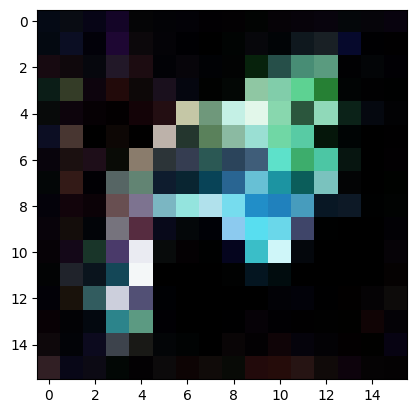

In [24]:
# Generate random noise
noise = torch.randn(1, latent_dim, 1, 1)  # Batch of 1 noise vector

G_unet_test = G_unet.to('cpu')
# Generate images
fake_images = G_unet_test(noise)

# Resize the generated image
resize_transform = transforms.Resize((16, 16))
resized_fake_images = resize_transform(fake_images)

# Convert to numpy array for visualization
image_noise = resized_fake_images.detach().numpy().reshape((3, 16, 16)) * 0.5 + 0.5

# Display the image
plt.imshow(np.transpose(image_noise, (1, 2, 0)))
plt.show()


<strong> Plotting losses </strong>

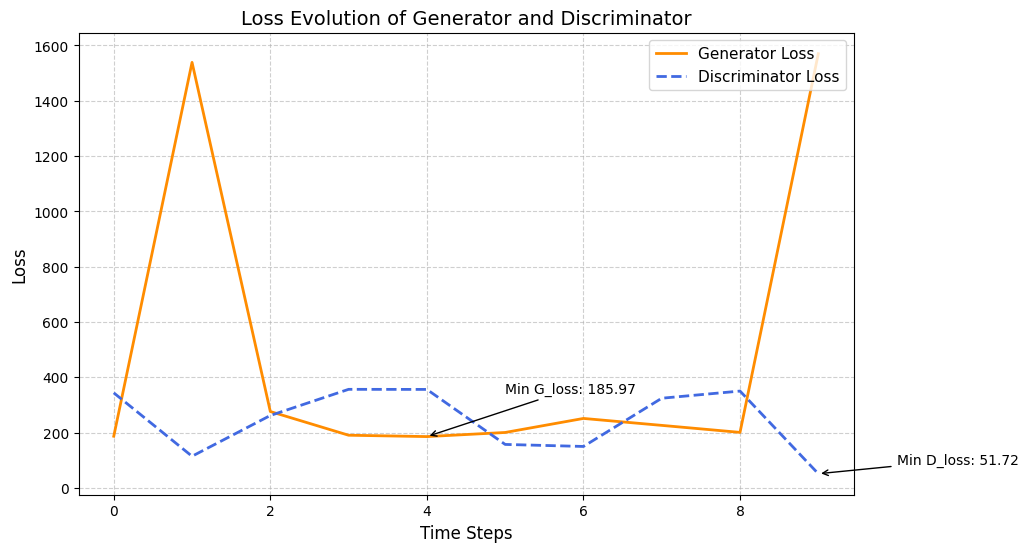

In [25]:
# Assuming G_loss and D_loss are defined
n = len(G_loss)
time_steps = [i for i in range(n)]

plt.figure(figsize=(10, 6))

# Plot Generator Loss
plt.plot(time_steps, G_loss, label='Generator Loss', color='darkorange', linestyle='-', linewidth=2)

# Plot Discriminator Loss
plt.plot(time_steps, D_loss, label='Discriminator Loss', color='royalblue', linestyle='--', linewidth=2)

# Add grid, labels, and title
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss Evolution of Generator and Discriminator', fontsize=14)

# Adding legend
plt.legend(loc='upper right', fontsize=11)

# Adding annotations for minimum loss points (optional)
min_G_loss = min(G_loss)
min_G_loss_idx = G_loss.index(min_G_loss)
plt.annotate(f'Min G_loss: {min_G_loss:.2f}', xy=(min_G_loss_idx, min_G_loss),
             xytext=(min_G_loss_idx + n*0.1, min_G_loss + max(G_loss)*0.1),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10)

min_D_loss = min(D_loss)
min_D_loss_idx = D_loss.index(min_D_loss)
plt.annotate(f'Min D_loss: {min_D_loss:.2f}', xy=(min_D_loss_idx, min_D_loss),
             xytext=(min_D_loss_idx + n*0.1, min_D_loss + max(D_loss)*0.1),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10)

# Show plot
plt.show()


<strong> Plotting FID (Fréchet Inception Distance) values </strong>

Text(0.5, 1.0, 'FID Evolution through training')

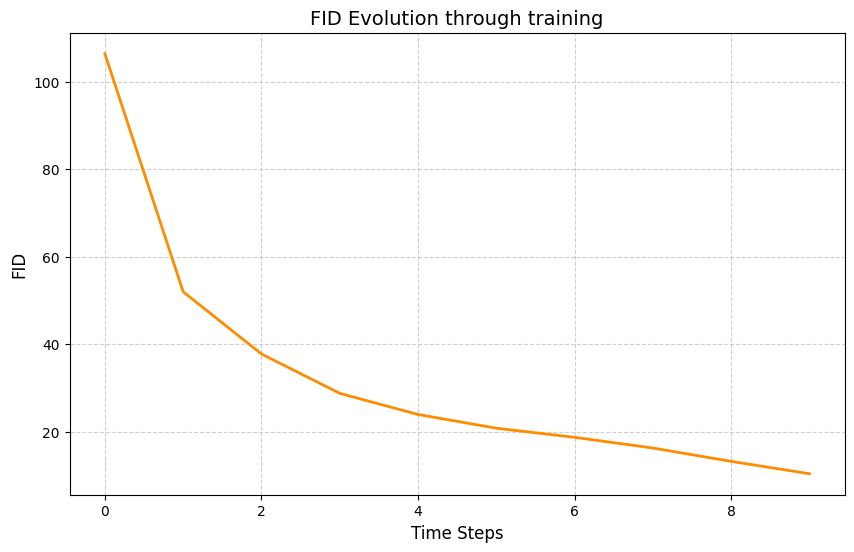

In [26]:
n = len(FID_values)
time_steps = [i for i in range(n)]

plt.figure(figsize=(10, 6))

# Plot FID values
plt.plot(time_steps, FID_values, label='Generator FID', color='darkorange', linestyle='-', linewidth=2)


# Add grid, labels, and title
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('FID', fontsize=12)
plt.title('FID Evolution through training', fontsize=14)